# Profiling and Preparing NYC Bicycle Counts Data 

A measure of bicycle activity would be useful for analyzing how vehicle collisions with cyclist vary with increased / decreased cycling activity. The City of New York publishes bicycle counts passing through several bicycle metering stations in the New York City area that could serve as a measure of overall cycling activity.


### Key Questions
- What fields are there and are they useful? 
- Are there significant gaps in the data over time?
- Is the dataset a reasonable proxy for cycling activity in New York City?


### Data Sources
- Bicycle Counts
    - https://data.cityofnewyork.us/Transportation/Bicycle-Counts/uczf-rk3c/about_data
- Counter Metadata
    - https://data.cityofnewyork.us/Transportation/Bicycle-Counters/smn3-rzf9/about_data

In [1]:
from datetime import datetime

import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandahelper as ph
from src import visualizations as viz
from src.constants import DAY_OF_WEEK_MAP, MONTHS_MAP
from src.strings import add_line_breaks
import src.utils

## Parameters

In [2]:
COUNT_DATA_LOC = "data/raw/bike/Bicycle_Counts.csv"
COUNTER_INFO_LOC = "data/raw/bike/Bicycle_Counters.csv"
PROCESSED_DATA_LOC = "data/processed/nyc_bike_counts.pkl"
MILLION = 1000000
THOUSAND = 1000

In [3]:
counts = pd.read_csv(COUNT_DATA_LOC)
counter_info = pd.read_csv(COUNTER_INFO_LOC)

In [4]:
counts.head()

countid         id                    date  counts  status
0  10347035  100009424  12/24/2018 03:30:00 AM       0       4
1  10347036  100009424  12/24/2018 03:45:00 AM       0       4
2  10347037  100009424  12/24/2018 04:00:00 AM       0       4
3  10347038  100009424  12/24/2018 04:15:00 AM       0       4
4  10347039  100009424  12/24/2018 04:30:00 AM       0       4

In [5]:
counter_info.head()

id                                        name             domain  \
0  100057318                         Broadway at 50th St  New York City DOT   
1  100010018                              Pulaski Bridge  New York City DOT   
2  300042336                                 Pelham Pkwy  New York City DOT   
3  100009426                   Manhattan Bridge Ped Path  New York City DOT   
4  100010019  Kent Ave btw North 8th St and North 9th St  New York City DOT   

    latitude  longitude  interval                    timezone  sens  \
0  40.761380 -73.984080        15  (UTC-05:00) US/Eastern;DST     5   
1  40.742563 -73.951492        15  (UTC-05:00) US/Eastern;DST     5   
2  40.857669 -73.856154        15  (UTC-05:00) US/Eastern;DST     5   
3  40.714573 -73.994950        15  (UTC-05:00) US/Eastern;DST     5   
4  40.720959 -73.960930        15  (UTC-05:00) US/Eastern;DST     5   

       counter  
0  Y2H18055362  
1  Y2H22042948  
2  Y2H22042938  
3  Y2H22042941  
4  Y2H22042949

Data can be merged / joined on "id" column which concurs with data dictionary for data sets as suggested in dataset dictionaries

In [6]:
counts["id"].dtype, counter_info["id"].dtype

(dtype('int64'), dtype('int64'))

In [7]:
counts = pd.merge(counts, counter_info, how="left", on="id")

There are no duplicated rows and few null values

## Profiling Data

In [8]:
ph.DataFrameProfile(counts)

DataFrame-Level Info
----------------------  -------------
DF Shape                (5589249, 13)
Duplicated Rows         0
Memory Usage (MB)       2,279.072

Series Name    Data Type      Memory Usage (MB)
-------------  -----------  -------------------
Index          int64                   0.000132
countid        int64                  44.714
id             int64                  44.714
date           object                396.837
counts         int64                  44.714
status         int64                  44.714
name           object                438.682
domain         object                368.89
latitude       float64                44.714
longitude      float64                44.714
interval       int64                  44.714
timezone       object                419.194
sens           int64                  44.714
counter        object                297.758

Summary of Nulls Per Row
--------------------------  ---------
Number of Columns           13
min                          0
1%                           0
5%                           0
25%                          0
50%                          0
75%                          0
95%                          1
99%                          1
max                          1
mean                         0.240237
standard deviation           0.427228
median                       0
median absolute deviation    0
skew                         1.21604

__Review of below series-level data profiles__

- `countid` is a row identifier that can be dropped
- `id` which corresponds to the bicycle counter has 34 separate counter ids with a varying number of observations
- `name` is a more useful name for "id"
- `date` is a timestamp with hour, minute, and seconds
- `domain` is always New York City DOT and can be dropped
- `latitiude` and "longitude" values should be checked for any nonsensical values (outide NYC area)
- `interval` values are not needed as every count has a datetime and the base unit of analysis will be hourly intervals
- All values in `timezone` are "(UTC-05:00) US/Eastern DST" and can be dropped
- All values in `sens` are 5 and can be dropped
- `counter` is a serial number (according to data dictionary) and is often null. We can drop this as well

In [9]:
ph.SeriesProfile(counts["countid"])

countid Info
--------------  -------
Data Type       int64
Count           5589249
Unique Values   5589249
Null Values     0

   Value    Count  % of total
--------  -------  ------------
10347035        1  0.00%
10347046        1  0.00%
10347038        1  0.00%
10347039        1  0.00%
10347040        1  0.00%
10347041        1  0.00%
10347042        1  0.00%
10347043        1  0.00%
10347044        1  0.00%
10347045        1  0.00%
84651765        1  0.00%
84651748        1  0.00%
84651747        1  0.00%
84651746        1  0.00%
84651766        1  0.00%

Statistic                        Value
-------------------------  -----------
count                      5.58925e+06
min                        1.00894e+07
1%                         1.02408e+07
5%                         1.06173e+07
25%                        1.18684e+07
50%                        1.38369e+07
75%                        1.69676e+07
95%                        6.98235e+07
99%                        8.19556e+07
max                        8.46518e+07
mean                       1.97804e+07
standard deviation         1.66409e+07
median                     1.38369e+07
median absolute deviation  2.50522e+06
skew                       2.6328

In [10]:
ph.SeriesProfile(counts["id"])

id Info
-------------  -------
Data Type      int64
Count          5589249
Unique Values  34
Null Values    0

    Value    Count  % of total
---------  -------  ------------
100062893   381148  6.82%
100047029   381148  6.82%
100009426   368665  6.60%
100009428   368504  6.59%
100009427   368433  6.59%
100010022   366111  6.55%
300020904   365948  6.55%
100010017   287203  5.14%
100009425   266080  4.76%
100010019   264522  4.73%
100057318    20544  0.37%
300038506    16276  0.29%
300038509    16267  0.29%
100039064    14998  0.27%
300040736     6761  0.12%

Statistic                          Value
-------------------------  -------------
count                        5.58925e+06
min                          1.00005e+08
1%                           1.00009e+08
5%                           1.00009e+08
25%                          1.00009e+08
50%                          1.0001e+08
75%                          1.00057e+08
95%                          3.00028e+08
99%                          3.00039e+08
max                          3.00042e+08
mean                         1.31231e+08
standard deviation           7.25763e+07
median                       1.0001e+08
median absolute deviation  597
skew                         1.89579

In [11]:
ph.SeriesProfile(counts["date"])

date Info
-------------  -------
Data Type      object
Count          5589249
Unique Values  413199
Null Values    0

Value                     Count  % of total
----------------------  -------  ------------
04/17/2024 04:30:00 AM       25  0.00%
06/07/2024 11:45:00 PM       25  0.00%
06/08/2024 05:30:00 PM       25  0.00%
06/08/2024 05:15:00 PM       25  0.00%
06/08/2024 05:00:00 PM       25  0.00%
06/08/2024 04:45:00 PM       25  0.00%
06/08/2024 04:30:00 PM       25  0.00%
06/08/2024 04:15:00 PM       25  0.00%
06/08/2024 04:00:00 PM       25  0.00%
06/08/2024 03:45:00 PM       25  0.00%
09/11/2013 08:30:00 PM        1  0.00%
09/11/2013 08:45:00 PM        1  0.00%
09/11/2013 09:00:00 PM        1  0.00%
09/11/2013 09:15:00 PM        1  0.00%
03/19/2013 04:00:00 AM        1  0.00%

In [12]:
ph.SeriesProfile(counts["counts"])

counts Info
-------------  -------
Data Type      int64
Count          5589249
Unique Values  897
Null Values    0

  Value    Count  % of total
-------  -------  ------------
      0   860809  15.40%
      1   373805  6.69%
      2   279622  5.00%
      3   217329  3.89%
      4   177636  3.18%
      5   150857  2.70%
      6   131232  2.35%
      7   117491  2.10%
      8   106717  1.91%
      9    98373  1.76%
    824        1  0.00%
   1092        1  0.00%
    925        1  0.00%
    894        1  0.00%
   1081        1  0.00%

Statistic                           Value
-------------------------  --------------
count                         5.58925e+06
min                           0
1%                            0
5%                            0
25%                           2
50%                          13
75%                          37
95%                          93
99%                         164
max                        1133
mean                         26.4127
standard deviation           39.3405
median                       13
median absolute deviation    13
skew                          5.17677

In [13]:
ph.SeriesProfile(counts["status"])

status Info
-------------  -------
Data Type      int64
Count          5589249
Unique Values  2
Null Values    0

  Value    Count  % of total
-------  -------  ------------
      0  4288109  76.72%
      4  1301140  23.28%

Statistic                        Value
-------------------------  -----------
count                      5.58925e+06
min                        0
1%                         0
5%                         0
25%                        0
50%                        0
75%                        0
95%                        4
99%                        4
max                        4
mean                       0.931173
standard deviation         1.69045
median                     0
median absolute deviation  0
skew                       1.26455

In [14]:
ph.SeriesProfile(counts["name"])

name Info
-------------  -------
Data Type      object
Count          5589249
Unique Values  34
Null Values    0

Value                                         Count  % of total
------------------------------------------  -------  ------------
Manhattan Bridge Bike Comprehensive          381148  6.82%
Manhattan Bridge Display Bike Counter        381148  6.82%
Manhattan Bridge Ped Path                    368665  6.60%
Ed Koch Queensboro Bridge Shared Path        368504  6.59%
Williamsburg Bridge Bike Path                368433  6.59%
Brooklyn Bridge Bike Path                    366111  6.55%
Comprehensive Brooklyn Bridge Counter        365948  6.55%
Staten Island Ferry                          287203  5.14%
Prospect Park West                           266080  4.76%
Kent Ave btw North 8th St and North 9th St   264522  4.73%
Broadway at 50th St                           20544  0.37%
High Bridge                                   16276  0.29%
Emmons Ave                                    16267  0.29%
Forsyth Plaza                                 14998  0.27%
Concrete Plant Park                            6761  0.12%

In [15]:
ph.SeriesProfile(counts["domain"])

domain Info
-------------  -------
Data Type      object
Count          5589249
Unique Values  1
Null Values    0

Value                Count  % of total
-----------------  -------  ------------
New York City DOT  5589249  100.00%

In [16]:
ph.SeriesProfile(counts["latitude"])

latitude Info
---------------  -------
Data Type        float64
Count            5589249
Unique Values    29
Null Values      0

  Value    Count  % of total
-------  -------  ------------
40.7156   762296  13.64%
40.7146   368665  6.60%
40.751    368504  6.59%
40.7105   368433  6.59%
40.7093   366111  6.55%
40.7116   365948  6.55%
40.7877   324850  5.81%
40.6434   287203  5.14%
40.6713   266080  4.76%
40.721    264522  4.73%
40.7614    20544  0.37%
40.8422    16276  0.29%
40.5841    16267  0.29%
40.7156    14998  0.27%
40.8277     6761  0.12%

Statistic                          Value
-------------------------  -------------
count                        5.58925e+06
min                          0
1%                          40.6243
5%                          40.6434
25%                         40.7093
50%                         40.7156
75%                         40.7426
95%                         40.7877
99%                         40.807
max                         40.8577
mean                        40.5201
standard deviation           2.8586
median                      40.7156
median absolute deviation    0.01579
skew                       -14.1017

In [17]:
ph.SeriesProfile(counts["longitude"])

longitude Info
----------------  -------
Data Type         float64
Count             5589249
Unique Values     29
Null Values       0

   Value    Count  % of total
--------  -------  ------------
-73.9947   762296  13.64%
-73.995    368665  6.60%
-73.9404   368504  6.59%
-73.9614   368433  6.59%
-74.001    366111  6.55%
-74.0041   365948  6.55%
-73.975    324850  5.81%
-74.0721   287203  5.14%
-73.9714   266080  4.76%
-73.9609   264522  4.73%
-73.9841    20544  0.37%
-73.9321    16276  0.29%
-73.931     16267  0.29%
-73.9947    14998  0.27%
-73.885      6761  0.12%

Statistic                          Value
-------------------------  -------------
count                        5.58925e+06
min                        -74.0721
1%                         -74.0721
5%                         -74.0721
25%                        -73.995
50%                        -73.9858
75%                        -73.9614
95%                        -73.9244
99%                        -73.8525
max                          0
mean                       -73.6128
standard deviation           5.19288
median                     -73.9858
median absolute deviation    0.01517
skew                        14.1045

In [18]:
ph.SeriesProfile(counts["interval"])

interval Info
---------------  -------
Data Type        int64
Count            5589249
Unique Values    3
Null Values      0

  Value    Count  % of total
-------  -------  ------------
     15  4498725  80.49%
     60  1028376  18.40%
      0    62148  1.11%

Statistic                         Value
-------------------------  ------------
count                       5.58925e+06
min                         0
1%                          0
5%                         15
25%                        15
50%                        15
75%                        15
95%                        60
99%                        60
max                        60
mean                       23.1128
standard deviation         17.586
median                     15
median absolute deviation   0
skew                        1.59368

In [19]:
ph.SeriesProfile(counts["timezone"])

timezone Info
---------------  -------
Data Type        object
Count            5589249
Unique Values    1
Null Values      0

Value                         Count  % of total
--------------------------  -------  ------------
(UTC-05:00) US/Eastern;DST  5589249  100.00%

In [20]:
ph.SeriesProfile(counts["sens"])

sens Info
-------------  -------
Data Type      int64
Count          5589249
Unique Values  1
Null Values    0

  Value    Count  % of total
-------  -------  ------------
      5  5589249  100.00%

Statistic                        Value
-------------------------  -----------
count                      5.58925e+06
min                        5
1%                         5
5%                         5
25%                        5
50%                        5
75%                        5
95%                        5
99%                        5
max                        5
mean                       5
standard deviation         0
median                     5
median absolute deviation  0
skew                       0

In [21]:
ph.SeriesProfile(counts["counter"])

counter Info
--------------  -------
Data Type       object
Count           4246503
Unique Values   23
Null Values     1342746

Value          Count  % of total
-----------  -------  ------------
Y2H21121587   762296  17.95%
Y2H22042941   368665  8.68%
Y2H22042947   368504  8.68%
Y2H22042936   368433  8.68%
Y2H22042940   366111  8.62%
Y2H22104568   287203  6.76%
Y2H21121588   266080  6.27%
Y2H22042949   264522  6.23%
Y2H22042948   243868  5.74%
Y2H22042942   195920  4.61%
Y2H22042938    21452  0.51%
Y2H18055362    20544  0.48%
YAH22104566    16276  0.38%
YAH22104564    16267  0.38%
YAH22104563     6761  0.16%

## Where are the counter stations located?

In [22]:
counts

countid         id                    date  counts  status  \
0        10347035  100009424  12/24/2018 03:30:00 AM       0       4   
1        10347036  100009424  12/24/2018 03:45:00 AM       0       4   
2        10347037  100009424  12/24/2018 04:00:00 AM       0       4   
3        10347038  100009424  12/24/2018 04:15:00 AM       0       4   
4        10347039  100009424  12/24/2018 04:30:00 AM       0       4   
...           ...        ...                     ...     ...     ...   
5589244  84651762  300042336  06/12/2024 10:45:00 PM       0       0   
5589245  84651763  300042336  06/12/2024 11:00:00 PM       1       0   
5589246  84651764  300042336  06/12/2024 11:15:00 PM       1       0   
5589247  84651765  300042336  06/12/2024 11:30:00 PM       3       0   
5589248  84651766  300042336  06/12/2024 11:45:00 PM       0       0   

                           name             domain   latitude  longitude  \
0        2nd Avenue - 26th St S  New York City DOT  40.739710 -73.979540   
1        2nd Avenue - 26th St S  New York City DOT  40.739710 -73.979540   
2        2nd Avenue - 26th St S  New York City DOT  40.739710 -73.979540   
3        2nd Avenue - 26th St S  New York City DOT  40.739710 -73.979540   
4        2nd Avenue - 26th St S  New York City DOT  40.739710 -73.979540   
...                         ...                ...        ...        ...   
5589244             Pelham Pkwy  New York City DOT  40.857669 -73.856154   
5589245             Pelham Pkwy  New York City DOT  40.857669 -73.856154   
5589246             Pelham Pkwy  New York City DOT  40.857669 -73.856154   
5589247             Pelham Pkwy  New York City DOT  40.857669 -73.856154   
5589248             Pelham Pkwy  New York City DOT  40.857669 -73.856154   

         interval                    timezone  sens      counter  
0              15  (UTC-05:00) US/Eastern;DST     5          NaN  
1              15  (UTC-05:00) US/Eastern;DST     5          NaN  
2              15  (UTC-05:00) US/Eastern;DST     5          NaN  
3              15  (UTC-05:00) US/Eastern;DST     5          NaN  
4              15  (UTC-05:00) US/Eastern;DST     5          NaN  
...           ...                         ...   ...          ...  
5589244        15  (UTC-05:00) US/Eastern;DST     5  Y2H22042938  
5589245        15  (UTC-05:00) US/Eastern;DST     5  Y2H22042938  
5589246        15  (UTC-05:00) US/Eastern;DST     5  Y2H22042938  
5589247        15  (UTC-05:00) US/Eastern;DST     5  Y2H22042938  
5589248        15  (UTC-05:00) US/Eastern;DST     5  Y2H22042938  

[5589249 rows x 13 columns]

In [23]:
map_center = (40.69, -73.92)
locations = set(
    zip(
        counts["latitude"],
        counts["longitude"],
        counts["name"],
    )
)
map_nyc = folium.Map(
    location=map_center, zoom_start=10, tiles="OpenStreetMap", width=600, height=600
)
for loc in locations:
    folium.Marker((loc[0], loc[1]), popup=loc[2], tooltip=loc[2]).add_to(map_nyc)
map_nyc

__Creating datetime field__

In [24]:
dt_fmt = "%m/%d/%Y %I:%M:%S %p"
counts.index = counts["date"].apply(lambda x: datetime.strptime(x, dt_fmt))
counts.index.names = ["datetime"]
counts = counts.sort_index()

In [25]:
counts.index.min(), counts.index.max()

(Timestamp('2012-08-31 00:00:00'), Timestamp('2024-06-13 23:45:00'))

In [26]:
cols_to_drop = [
    "countid",
    "id",
    "domain",
    "interval",
    "timezone",
    "sens",
    "counter",
    "date",
    "status",
]
counts = counts.drop(cols_to_drop, axis=1)

## Checking for temporal gaps in data

The dataset as a whole does not appears to have major gaps. The longest period of time without an observation is ~ 6 hours. Most of the 1 hour and 15 minute gaps correspond to time changes due to daylight savings time and do not represent a true gap in data

In [27]:
ph.frequency_table(ph.time_diffs_index(counts))

Count % of Total
0 days 00:00:00  5176050     92.61%
0 days 00:15:00   413183      7.39%
0 days 01:15:00       12      0.00%
0 days 02:15:00        1      0.00%
0 days 00:30:00        1      0.00%
0 days 06:15:00        1      0.00%

There is a wide range in how much data is available per counter station

In [28]:
ph.category_gaps(counts["name"], threshold=pd.Timedelta(hours=1))

Cumulative Gap
Concrete Plant Park                                4234 days 13:45:00
Forsyth Plaza                                      4148 days 16:15:00
Emmons Ave                                         4135 days 12:30:00
High Bridge                                        4135 days 10:15:00
Broadway at 50th St                                4090 days 10:30:00
Pelham Pkwy                                        4081 days 12:15:00
Ocean Pkwy at Avenue J                             4021 days 00:15:00
Manhattan Bridge Interference Calibration 2019 ... 4016 days 15:00:00
Manhattan Bridge 2012 Test Bike Counter            3928 days 01:30:00
Willis Ave Bikes                                   3657 days 12:45:00
Willis Ave                                         3657 days 12:45:00
Willis Ave Peds                                    3657 days 12:45:00
Fountain Ave                                       3647 days 01:45:00
111th St at 50th Ave                               3548 days 21:45:00
Kent Ave btw South 6th St. and Broadway            3487 days 06:30:00
Brooklyn Bridge Bicycle Path (Roadway)             3305 days 06:45:00
2nd Avenue - 26th St S                             2884 days 02:30:00
Amsterdam Ave at 86th St.                          2613 days 09:30:00
Columbus Ave at 86th St.                           2612 days 06:00:00
Manhattan Bridge 2013 to 2018 Bike Counter         2580 days 19:15:00
8th Ave at 50th St.                                2263 days 19:00:00
Manhattan Bridge 2012 to 2019 Bike Counter         2192 days 07:30:00
1st Avenue - 26th St N - Interference testing      2032 days 00:00:00
Pulaski Bridge                                     1764 days 08:45:00
Kent Ave btw North 8th St and North 9th St         1549 days 04:30:00
Prospect Park West                                 1533 days 00:30:00
Staten Island Ferry                                1312 days 22:15:00
Comprehensive Brooklyn Bridge Counter               492 days 13:45:00
Brooklyn Bridge Bike Path                           490 days 21:45:00
Williamsburg Bridge Bike Path                       466 days 15:00:00
Ed Koch Queensboro Bridge Shared Path               465 days 22:45:00
Manhattan Bridge Ped Path                           464 days 07:15:00
Manhattan Bridge Display Bike Counter               333 days 14:45:00
Manhattan Bridge Bike Comprehensive                 333 days 14:45:00

### Manhattan Bridge

There are several Manhattan Bridge stations. `Manhattan Bridge Bike Comprehensive` frequently appears to be contain bike counts for all the other bike counters except `Manhattan Bridge Ped Path`. The data dictionary for the counter dataset explains that most of the Manhattan Bridge recorded values are overlapping with the exception of the Pedestrian Path.

In [29]:
mb = counts[counts["name"].apply(lambda x: "Manhattan Bridge" in x)]

In [30]:
table = pd.pivot_table(
    mb, index=mb.index, columns=mb["name"], values="counts", aggfunc="sum"
)
corr_matrix = table.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix[mask] = np.nan
corr_matrix.style.background_gradient(cmap="Blues", axis=None, low=0.6).highlight_null(
    color="#f1f1f1"
).format(precision=2)

In [31]:
for name in mb["name"].unique():
    counter = mb[mb["name"] == name]
    s = f"{name}\nMin time: {counter.index.min()}\nMax time: {counter.index.max()}\n"
    print(s, ph.id_gaps_index(counter, pd.Timedelta(hours=1)), "\n")

Manhattan Bridge Bike Comprehensive
Min time: 2012-08-31 00:00:00
Max time: 2024-06-13 23:45:00
                                 diffs
datetime                             
2013-12-03 00:00:00 328 days 00:15:00
2023-09-27 02:15:00   2 days 02:30:00
2024-01-21 02:15:00   1 days 02:30:00
2023-07-03 02:15:00   1 days 02:30:00
2023-07-01 02:15:00   1 days 02:30:00
2013-12-03 11:00:00   0 days 06:15:00
2012-10-12 15:00:00   0 days 02:15:00
2021-03-14 03:00:00   0 days 01:15:00
2023-03-12 03:00:00   0 days 01:15:00
2022-03-13 03:00:00   0 days 01:15:00
2019-03-10 03:00:00   0 days 01:15:00
2020-03-08 03:00:00   0 days 01:15:00
2018-03-11 03:00:00   0 days 01:15:00
2017-03-12 03:00:00   0 days 01:15:00
2016-03-13 03:00:00   0 days 01:15:00
2015-03-08 03:00:00   0 days 01:15:00
2014-11-04 05:00:00   0 days 01:15:00
2014-03-09 03:00:00   0 days 01:15:00
2024-03-10 03:00:00   0 days 01:15:00 

Manhattan Bridge Display Bike Counter
Min time: 2012-08-31 00:00:00
Max time: 2024-06-13 23:45:00
     

`Manhattan Bridge Bike Comprehensive` is generally the maximum value amongst the Manhattan Bridge measurements

In [32]:
table_with_fill = pd.pivot_table(
    mb, index=mb.index, columns=mb["name"], values="counts", aggfunc="sum", fill_value=0
)
sum(
    table_with_fill.max(axis=1)
    == table_with_fill["Manhattan Bridge Bike Comprehensive"]
) / len(table_with_fill)

0.9721988455055417

When `Manhattan Bridge Bike Comprehensive` is not the maximum value among the different counters, it tends differ from the max by ~26%

In [33]:
table_wo_ped_path = table_with_fill.drop(["Manhattan Bridge Ped Path"], axis=1)

In [34]:
different_max = table_wo_ped_path[
    ~(
        table_wo_ped_path.max(axis=1)
        == table_wo_ped_path["Manhattan Bridge Bike Comprehensive"]
    )
]
different_max.head(15)

name                 Manhattan Bridge 2012 Test Bike Counter  \
datetime                                                       
2018-08-23 00:00:00                                        0   
2018-08-23 00:30:00                                        0   
2018-08-23 00:45:00                                        0   
2018-08-23 01:15:00                                        0   
2018-08-23 01:30:00                                        0   
2018-08-23 02:45:00                                        0   
2018-08-23 03:00:00                                        0   
2018-08-23 03:15:00                                        0   
2018-08-23 04:15:00                                        0   
2018-08-23 05:15:00                                        0   
2018-08-23 06:15:00                                        0   
2018-08-23 06:30:00                                        0   
2018-08-23 07:15:00                                        0   
2018-08-23 08:00:00                                        0   
2018-08-23 08:15:00                                        0   

name                 Manhattan Bridge 2012 to 2019 Bike Counter  \
datetime                                                          
2018-08-23 00:00:00                                          19   
2018-08-23 00:30:00                                          13   
2018-08-23 00:45:00                                           7   
2018-08-23 01:15:00                                           7   
2018-08-23 01:30:00                                           4   
2018-08-23 02:45:00                                           2   
2018-08-23 03:00:00                                           1   
2018-08-23 03:15:00                                           0   
2018-08-23 04:15:00                                           1   
2018-08-23 05:15:00                                           9   
2018-08-23 06:15:00                                          16   
2018-08-23 06:30:00                                          21   
2018-08-23 07:15:00                                          30   
2018-08-23 08:00:00                                          70   
2018-08-23 08:15:00                                         103   

name                 Manhattan Bridge 2013 to 2018 Bike Counter  \
datetime                                                          
2018-08-23 00:00:00                                          22   
2018-08-23 00:30:00                                          18   
2018-08-23 00:45:00                                          12   
2018-08-23 01:15:00                                           8   
2018-08-23 01:30:00                                           5   
2018-08-23 02:45:00                                           4   
2018-08-23 03:00:00                                           2   
2018-08-23 03:15:00                                           2   
2018-08-23 04:15:00                                           2   
2018-08-23 05:15:00                                          14   
2018-08-23 06:15:00                                          20   
2018-08-23 06:30:00                                          26   
2018-08-23 07:15:00                                          36   
2018-08-23 08:00:00                                          74   
2018-08-23 08:15:00                                         111   

name                 Manhattan Bridge Bike Comprehensive  \
datetime                                                   
2018-08-23 00:00:00                                   19   
2018-08-23 00:30:00                                   13   
2018-08-23 00:45:00                                    7   
2018-08-23 01:15:00                                    7   
2018-08-23 01:30:00                                    4   
2018-08-23 02:45:00                                    2   
2018-08-23 03:00:00                                    1   
2018-08-23 03:15:00                                    0   
2018-08-23 04:15:00            

In [35]:
(
    (different_max.max(axis=1) - different_max["Manhattan Bridge Bike Comprehensive"])
    / different_max.max(axis=1)
).mean()

0.26217542667432336

We will create a measure of Manhattan Bridge crossings by taking the sum of the max counter value from the various Manhattan Bridge counter recordings (excluding the pedestrian path) and the counter value on the Pedestrian Path. Our Manhattan Bridge measure is complete enough to be useful as a component of a bicycle activity index from 2014 onwards.

In [36]:
mb_count = table_wo_ped_path.max(axis=1) + table_with_fill["Manhattan Bridge Ped Path"]
mb_count.name = "Manhattan Bridge Combined"

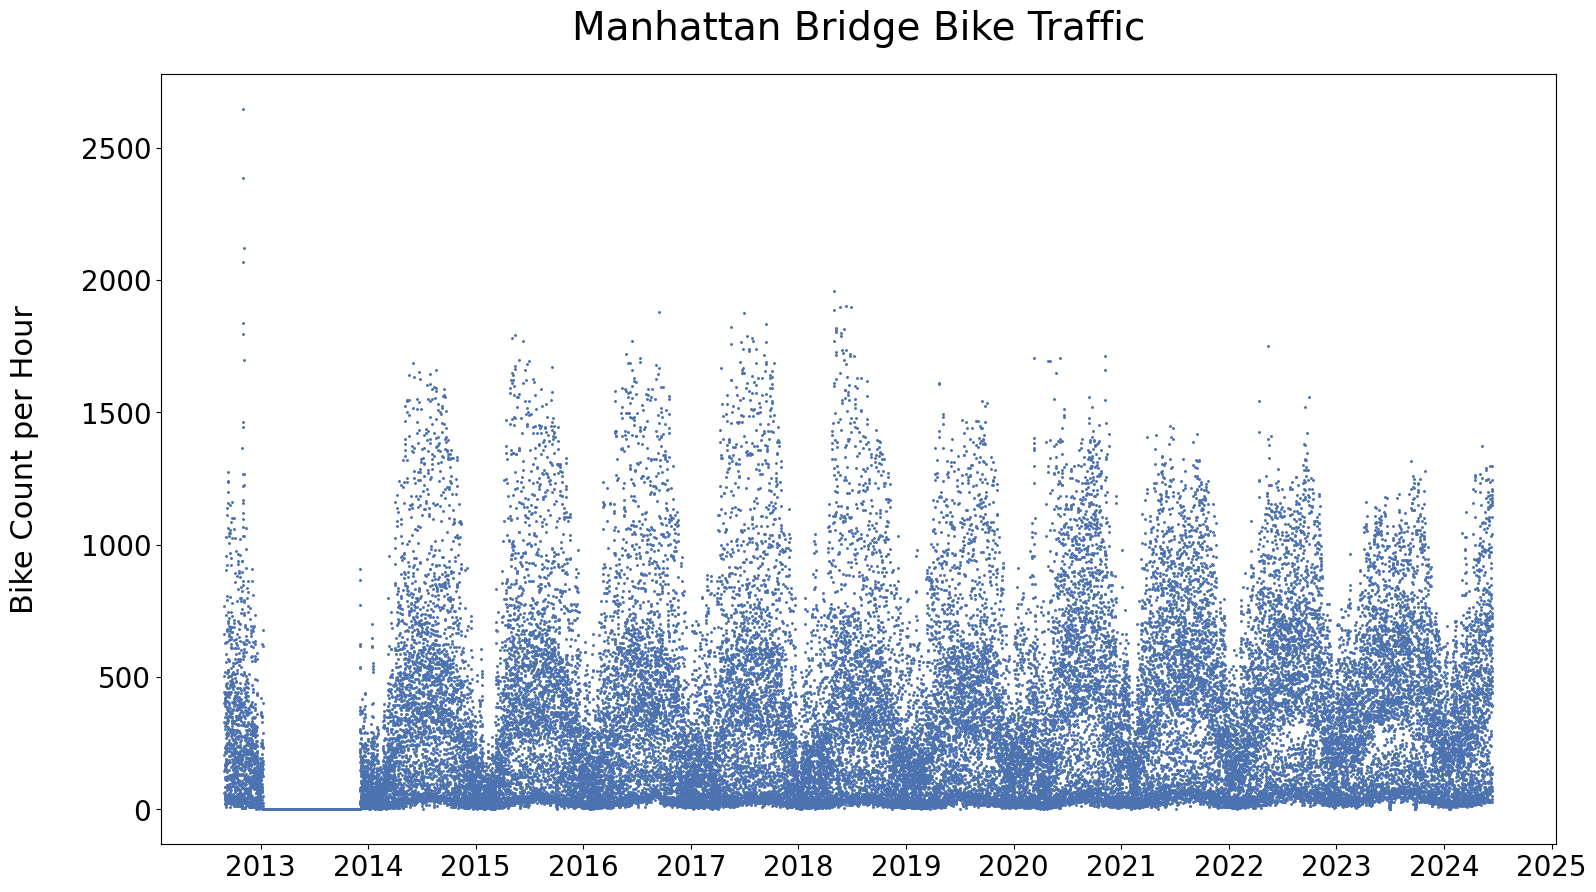

In [37]:
mb_2hr = mb_count.resample("2h").sum()
scatter_params = {
    "title": "Manhattan Bridge Bike Traffic",
    "ylabel": "Bike Count per Hour",
    "ylabel_rotation": "vertical",
}
with plt.style.context("default"):
    fig, ax = viz.setup_chart(**scatter_params)
    ax.scatter(mb_2hr.index, mb_2hr, s=5, marker=".")
    ax.xaxis.set_major_locator(mpl.dates.YearLocator(1))
    plt.show()

### Ed Koch Queensboro Bridge Shared Path
The Queensboro Bridge data is complete enough to be useful as a component of a bicycle activity index.

In [38]:
qbb = counts[counts["name"] == "Ed Koch Queensboro Bridge Shared Path"]
qbb.index.min(), qbb.index.max()

(Timestamp('2013-12-05 11:15:00'), Timestamp('2024-06-13 23:45:00'))

In [39]:
ph.id_gaps_index(qbb, pd.Timedelta(hours=1))

diffs
datetime                           
2019-06-11 05:00:00 1 days 05:15:00
2023-07-02 02:15:00 1 days 02:30:00
2024-01-02 02:15:00 1 days 02:30:00
2024-01-05 02:15:00 1 days 02:30:00
2014-03-09 03:00:00 0 days 01:15:00
2015-03-08 03:00:00 0 days 01:15:00
2016-03-13 03:00:00 0 days 01:15:00
2017-03-12 03:00:00 0 days 01:15:00
2018-03-11 03:00:00 0 days 01:15:00
2019-03-10 03:00:00 0 days 01:15:00
2020-03-08 03:00:00 0 days 01:15:00
2021-03-14 03:00:00 0 days 01:15:00
2022-03-13 03:00:00 0 days 01:15:00
2023-03-12 03:00:00 0 days 01:15:00
2024-03-10 03:00:00 0 days 01:15:00

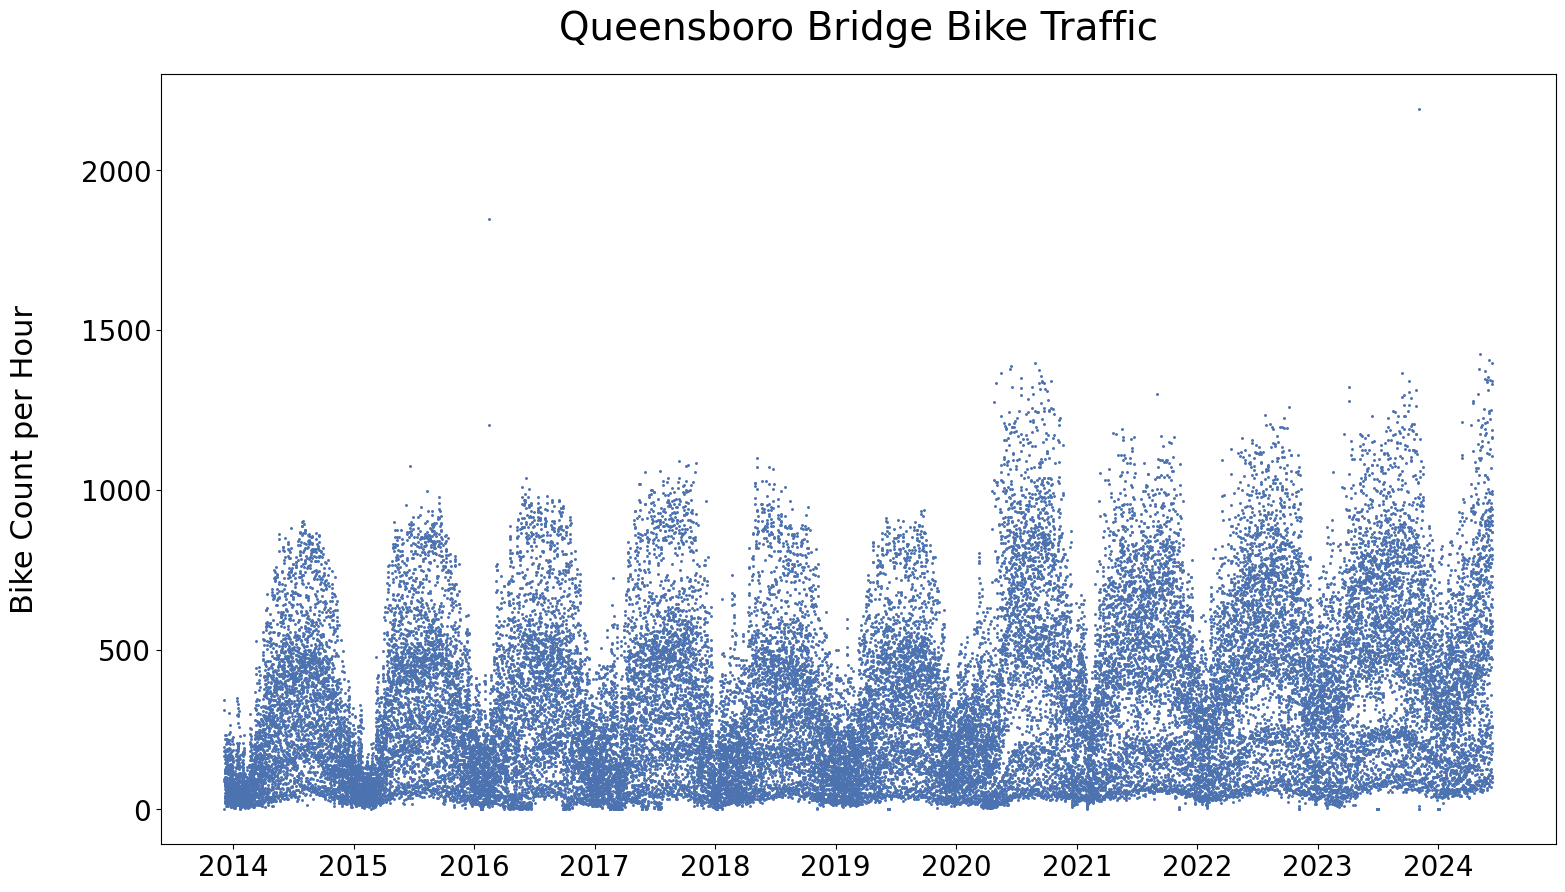

In [40]:
qbb_2hr = qbb.resample("2h")["counts"].sum()
scatter_params = {
    "title": "Queensboro Bridge Bike Traffic",
    "ylabel": "Bike Count per Hour",
    "ylabel_rotation": "vertical",
}
with plt.style.context("default"):
    fig, ax = viz.setup_chart(**scatter_params)
    ax.scatter(qbb_2hr.index, qbb_2hr.values, s=5, marker=".")
    ax.xaxis.set_major_locator(mpl.dates.YearLocator(1))
    plt.show()

### Williamsburg Bridge Bike Path
The Williamsburg Bridge data is complete enough to be useful as a component of a bicycle activity index.

In [41]:
wb = counts[counts["name"] == "Williamsburg Bridge Bike Path"]
wb.index.min(), wb.index.max()

(Timestamp('2013-12-03 14:45:00'), Timestamp('2024-06-13 23:45:00'))

In [42]:
ph.id_gaps_index(wb, pd.Timedelta(hours=1))

diffs
datetime                           
2024-01-31 04:30:00 1 days 04:45:00
2023-09-08 04:30:00 1 days 04:45:00
2023-08-30 04:30:00 1 days 04:45:00
2023-08-03 04:30:00 1 days 04:45:00
2023-07-02 04:30:00 1 days 04:45:00
2023-11-05 03:30:00 1 days 03:45:00
2014-03-09 03:00:00 0 days 01:15:00
2023-03-12 03:00:00 0 days 01:15:00
2022-03-13 03:00:00 0 days 01:15:00
2015-03-08 03:00:00 0 days 01:15:00
2021-03-14 03:00:00 0 days 01:15:00
2020-03-08 03:00:00 0 days 01:15:00
2019-03-10 03:00:00 0 days 01:15:00
2018-03-11 03:00:00 0 days 01:15:00
2017-03-12 03:00:00 0 days 01:15:00
2016-03-13 03:00:00 0 days 01:15:00
2024-03-10 03:00:00 0 days 01:15:00

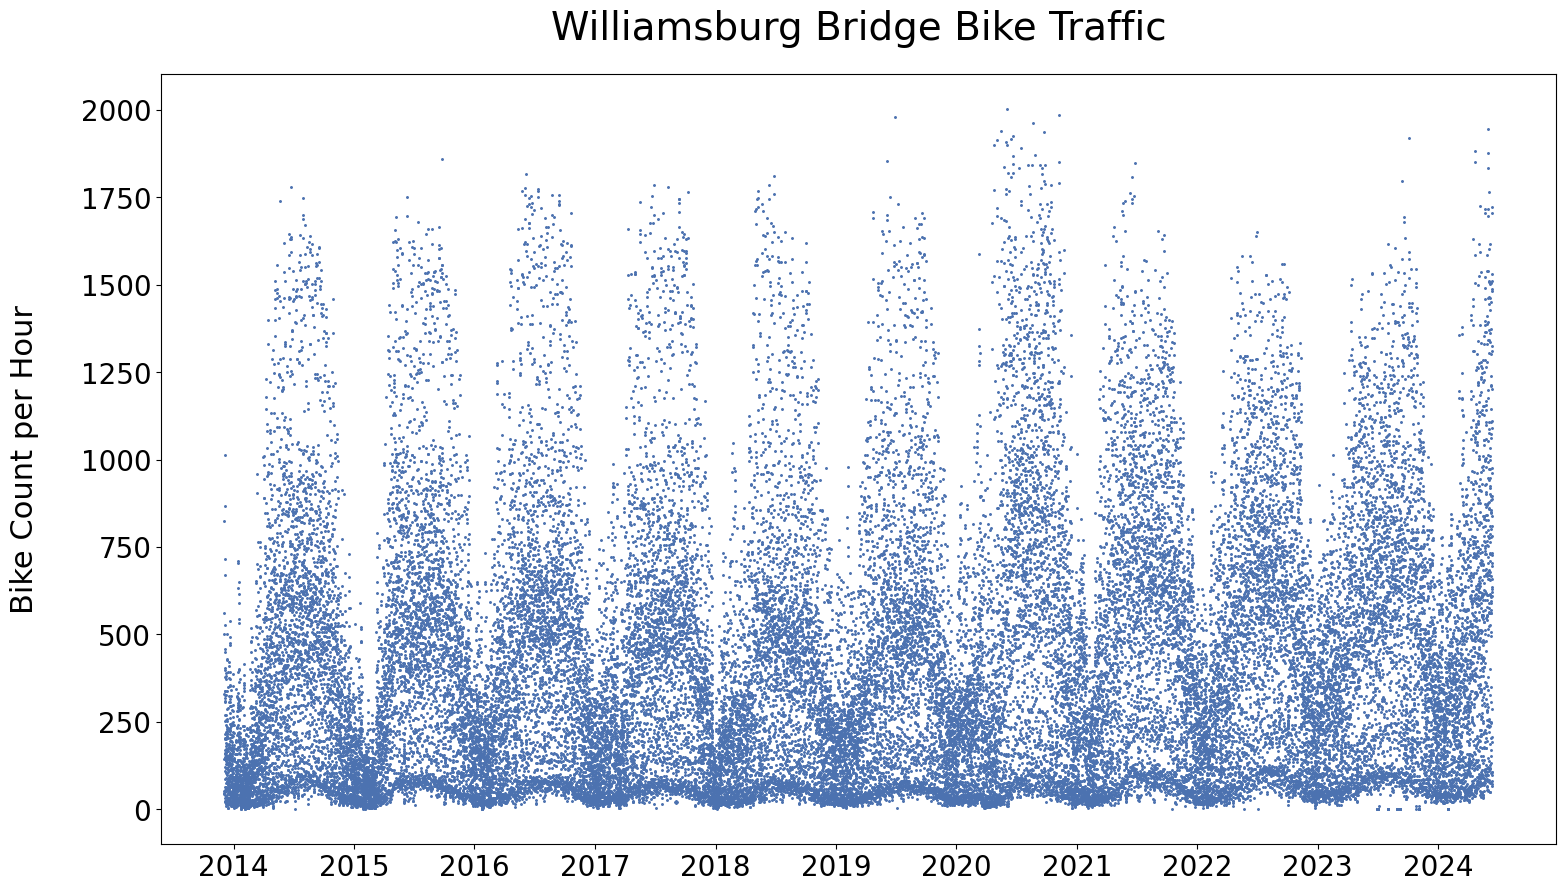

In [43]:
wb_2hr = wb.resample("2h")["counts"].sum()
scatter_params = {
    "title": "Williamsburg Bridge Bike Traffic",
    "ylabel": "Bike Count per Hour",
    "ylabel_rotation": "vertical",
}
with plt.style.context("default"):
    fig, ax = viz.setup_chart(**scatter_params)
    ax.scatter(wb_2hr.index, wb_2hr.values, s=5, marker=".")
    ax.xaxis.set_major_locator(mpl.dates.YearLocator(1))
    plt.show()

### Brooklyn Bridge
The Comprehensive Brooklyn Bridge Counter is complete enough to be useful as a component of a bicycle activity index. It should be noted that it has an approximately 2 month gap in the fall of 2014.

In [44]:
bb = counts[counts["name"].apply(lambda x: "Brooklyn Bridge" in x)]

In [45]:
bb_table = pd.pivot_table(
    bb, index=bb.index, columns=bb["name"], values="counts", aggfunc="sum"
)
corr_matrix = bb_table.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix[mask] = np.nan
corr_matrix.style.background_gradient(cmap="Blues", axis=None, low=0.6).highlight_null(
    color="#f1f1f1"
).format(precision=2)

In [46]:
bb_comp = (
    bb[bb["name"] == "Comprehensive Brooklyn Bridge Counter"]
    .resample("1h")["counts"]
    .sum()
)
bb_bike = bb[bb["name"] == "Brooklyn Bridge Bike Path"].resample("1h")["counts"].sum()
bb_roadway = (
    bb[bb["name"] == "Brooklyn Bridge Bicycle Path (Roadway)"]
    .resample("1h")["counts"]
    .sum()
)

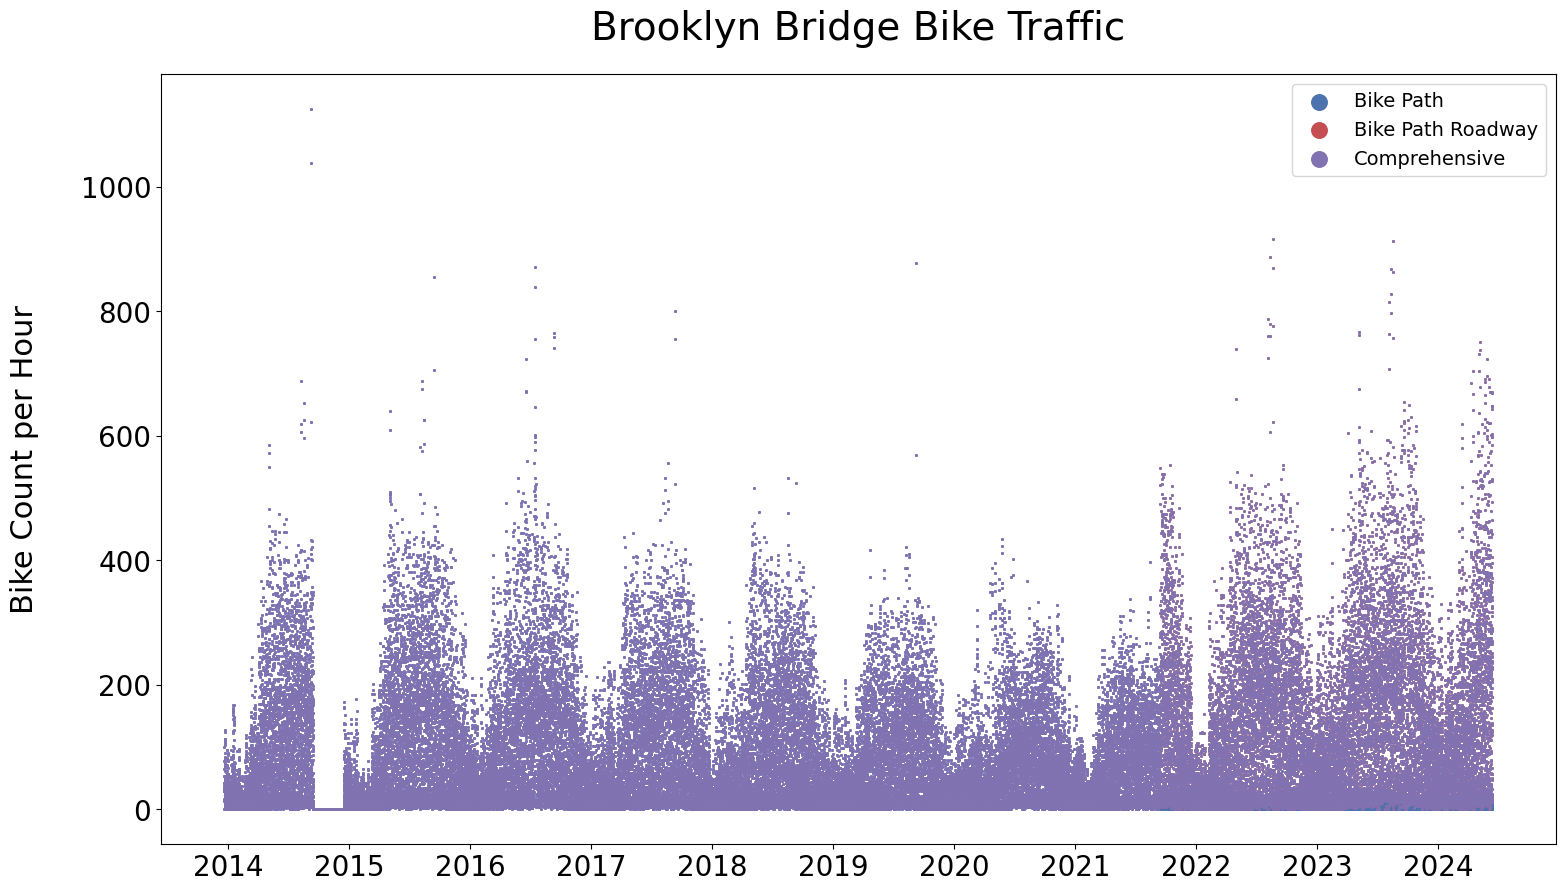

In [47]:
scatter_params = {
    "title": "Brooklyn Bridge Bike Traffic",
    "ylabel": "Bike Count per Hour",
    "ylabel_rotation": "vertical",
}
with plt.style.context("default"):
    fig, ax = viz.setup_chart(**scatter_params)
    ax.scatter(bb_bike.index, bb_bike.values, s=5, marker=".")
    ax.scatter(bb_roadway.index, bb_roadway.values, s=5, marker=".")
    ax.scatter(bb_comp.index, bb_comp.values, s=5, marker=".")
    ax.xaxis.set_major_locator(mpl.dates.YearLocator(1))
    ax.legend(
        ["Bike Path", "Bike Path Roadway", "Comprehensive"], fontsize=14, markerscale=10
    )
    plt.show()

It looks like most but not all of the bike traffic on the Brooklyn Bridge shifted from the `Bike Path` counter to the `Bike Path Roadway` counter in 2021.

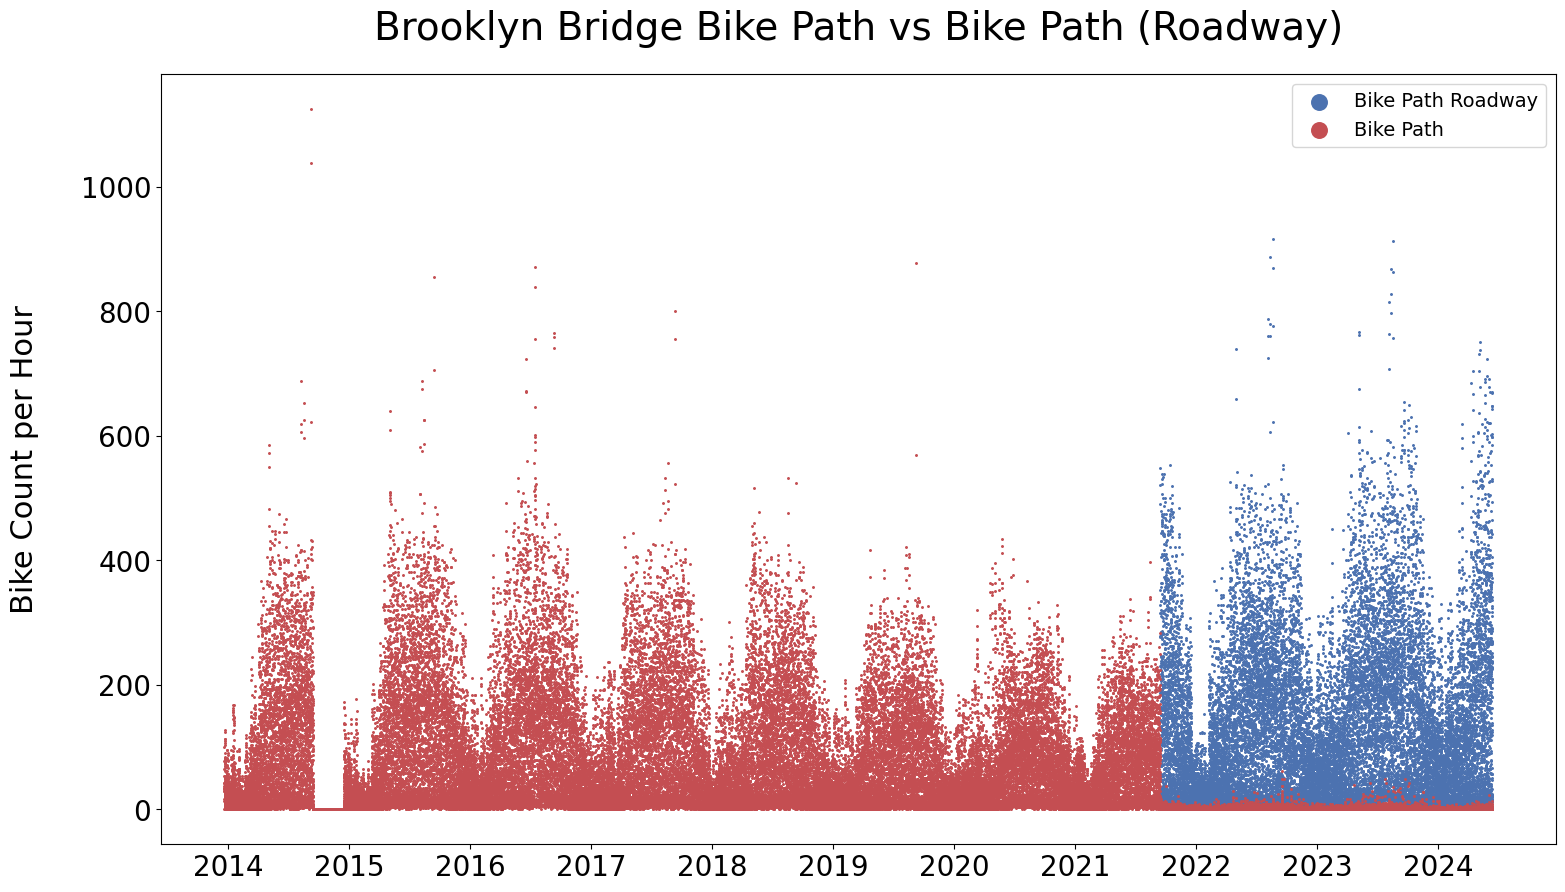

In [48]:
scatter_params = {
    "title": "Brooklyn Bridge Bike Path vs Bike Path (Roadway)",
    "ylabel": "Bike Count per Hour",
    "ylabel_rotation": "vertical",
}
with plt.style.context("default"):
    fig, ax = viz.setup_chart(**scatter_params)
    ax.scatter(
        bb_roadway.index, bb_roadway.values, s=5, marker=".", label="Bike Path Roadway"
    )
    ax.scatter(bb_bike.index, bb_bike.values, s=5, marker=".", label="Bike Path")
    ax.xaxis.set_major_locator(mpl.dates.YearLocator(1))
    ax.legend(fontsize=14, markerscale=10)
    plt.show()

It appears that `Comprehensive Brooklyn Bridge Counter` is a good single measure of Brooklyn Bridge traffic. It is the maximum value among the three Brooklyn Bridge counters 99.7% of the time

In [49]:
bb_table_with_fill = pd.pivot_table(
    bb, index=bb.index, columns=bb["name"], values="counts", aggfunc="sum", fill_value=0
)
sum(
    bb_table_with_fill.max(axis=1)
    == bb_table_with_fill["Comprehensive Brooklyn Bridge Counter"]
) / len(bb_table_with_fill)

0.9970298137900723

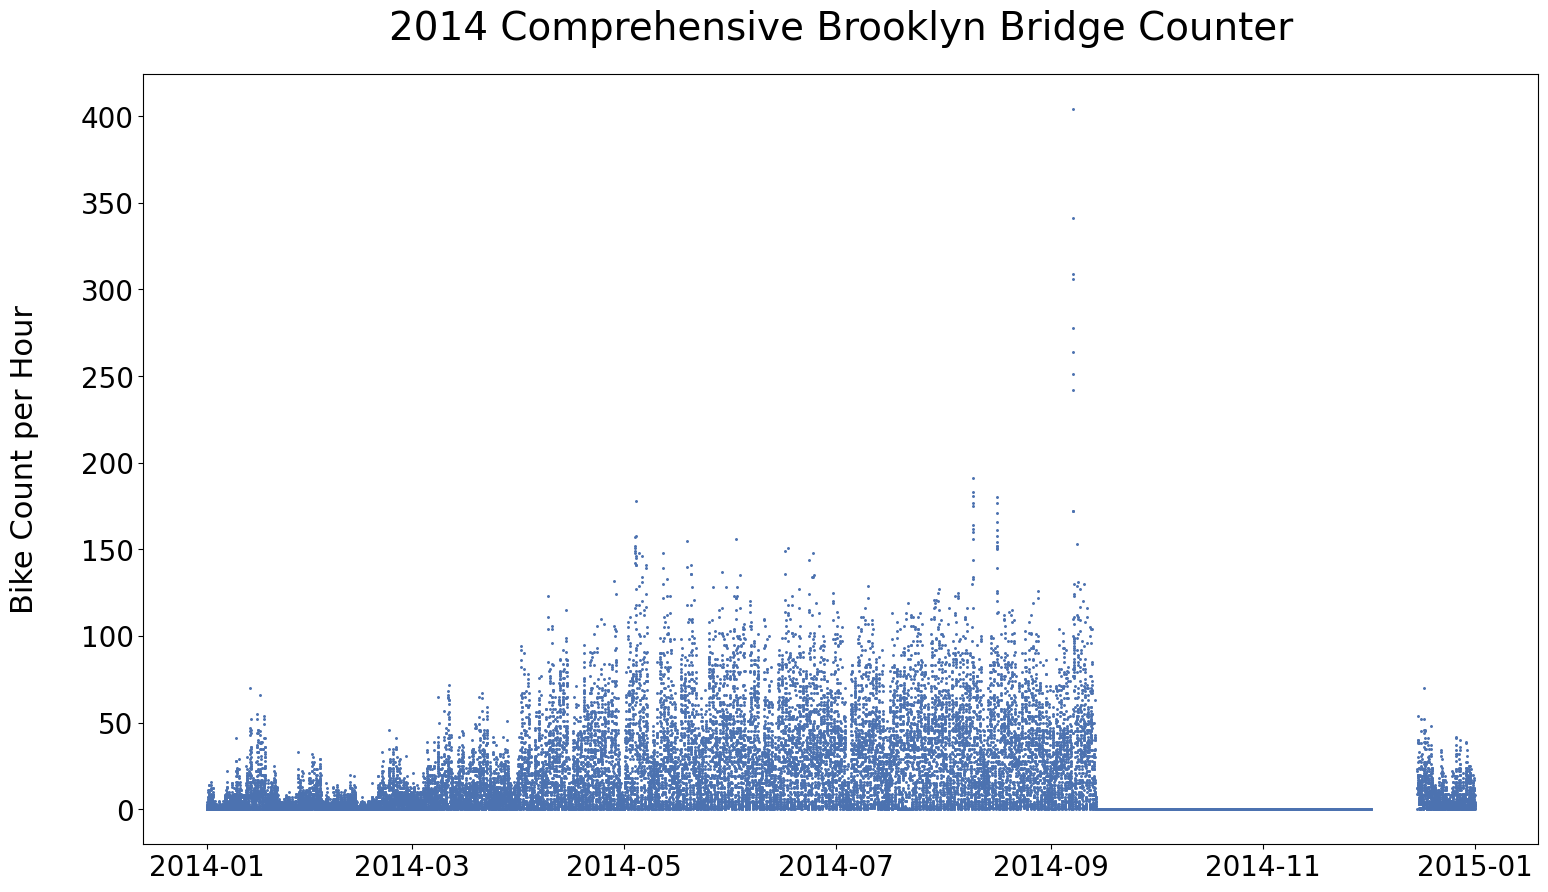

In [50]:
bb_comp_2014 = bb[
    (bb["name"] == "Comprehensive Brooklyn Bridge Counter") & (bb.index.year == 2014)
]["counts"]
scatter_params = {
    "title": "2014 Comprehensive Brooklyn Bridge Counter",
    "ylabel": "Bike Count per Hour",
    "ylabel_rotation": "vertical",
}
with plt.style.context("default"):
    fig, ax = viz.setup_chart(**scatter_params)
    ax.scatter(bb_comp_2014.index, bb_comp_2014.values, s=5, marker=".")
    plt.show()

In [51]:
ph.id_gaps_index(
    bb[bb["name"] == "Comprehensive Brooklyn Bridge Counter"], pd.Timedelta(hours=1)
)

diffs
datetime                            
2014-12-15 10:15:00 13 days 10:30:00
2023-09-07 01:15:00  1 days 15:30:00
2023-07-03 01:15:00  1 days 01:30:00
2023-09-28 01:15:00  1 days 01:30:00
2014-03-09 03:00:00  0 days 01:15:00
2015-03-08 03:00:00  0 days 01:15:00
2016-03-13 03:00:00  0 days 01:15:00
2017-03-12 03:00:00  0 days 01:15:00
2018-03-11 03:00:00  0 days 01:15:00
2019-03-10 03:00:00  0 days 01:15:00
2020-03-08 03:00:00  0 days 01:15:00
2021-03-14 03:00:00  0 days 01:15:00
2022-03-13 03:00:00  0 days 01:15:00
2023-03-12 03:00:00  0 days 01:15:00
2024-03-10 03:00:00  0 days 01:15:00

### Staten Island Ferry
The Staten Island Ferry counter data is reasonably complete going back to 2016. It can be included in a composite measure of bike activity but the magnitude of bike activity is generally small relative to the major East River bridges (Brooklyn, Manhattan, Williamsburg, Queensboro).

In [52]:
si = counts[counts["name"] == "Staten Island Ferry"]
si.index.min(), si.index.max()

(Timestamp('2016-03-31 04:00:00'), Timestamp('2024-06-13 23:45:00'))

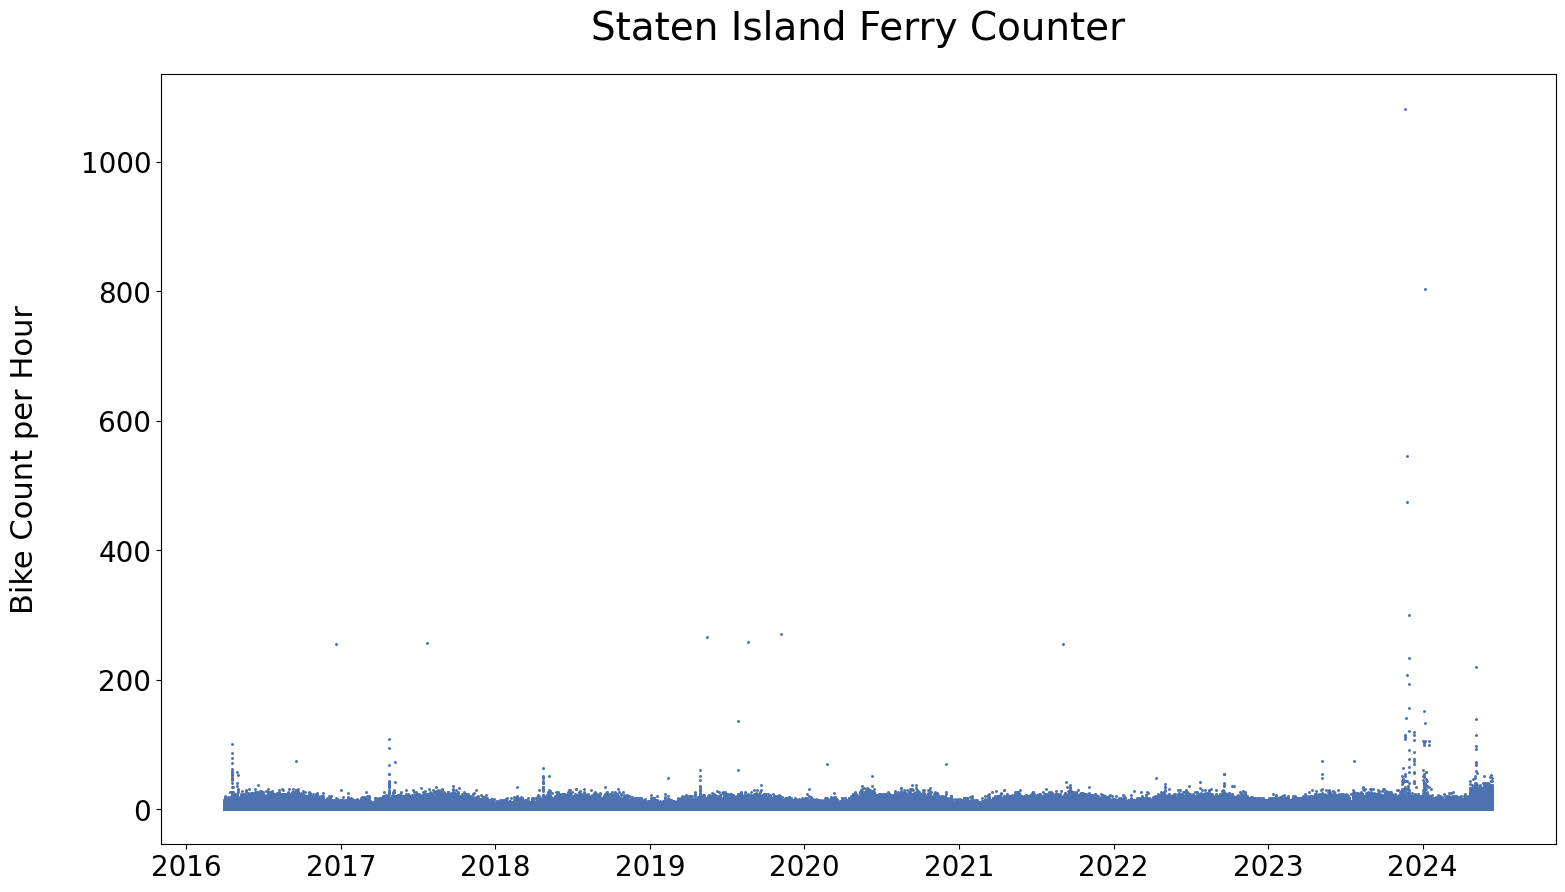

In [53]:
scatter_params = {
    "title": "Staten Island Ferry Counter",
    "ylabel": "Bike Count per Hour",
    "ylabel_rotation": "vertical",
}
with plt.style.context("default"):
    fig, ax = viz.setup_chart(**scatter_params)
    ax.scatter(si.index, si["counts"].values, s=5, marker=".")
    plt.show()

In [54]:
ph.id_gaps_index(counts[counts["name"] == "Staten Island Ferry"], pd.Timedelta(hours=1))

diffs
datetime                           
2023-07-03 02:30:00 2 days 02:45:00
2023-06-01 02:30:00 1 days 02:45:00
2023-11-04 02:30:00 1 days 02:45:00
2022-12-02 11:45:00 0 days 12:00:00
2017-03-12 03:00:00 0 days 01:15:00
2018-03-11 03:00:00 0 days 01:15:00
2019-03-10 03:00:00 0 days 01:15:00
2020-03-08 03:00:00 0 days 01:15:00
2021-03-14 03:00:00 0 days 01:15:00
2022-03-13 03:00:00 0 days 01:15:00
2023-03-12 03:00:00 0 days 01:15:00
2024-03-10 03:00:00 0 days 01:15:00

In [55]:
ph.distribution_stats(si["counts"])

Statistic Value
count                        287203.000000
min                               0.000000
1%                                0.000000
5%                                0.000000
25%                               0.000000
50%                               3.000000
75%                               7.000000
95%                              14.000000
99%                              20.000000
max                            1081.000000
mean                              4.301216
standard deviation                5.975218
median                            3.000000
median absolute deviation         3.000000
skew                             37.339923

### Prospect Park West
The Prospect Park West counter does not appear to be a good candidate to include in a measure of bike activity. Its data stream does not begin until late 2016 and has a notable gap in 2023/2024.

In [56]:
ppw = counts[counts["name"] == "Prospect Park West"]["counts"]
ppw.index.min(), ppw.index.max()

(Timestamp('2016-11-07 16:30:00'), Timestamp('2024-06-13 23:45:00'))

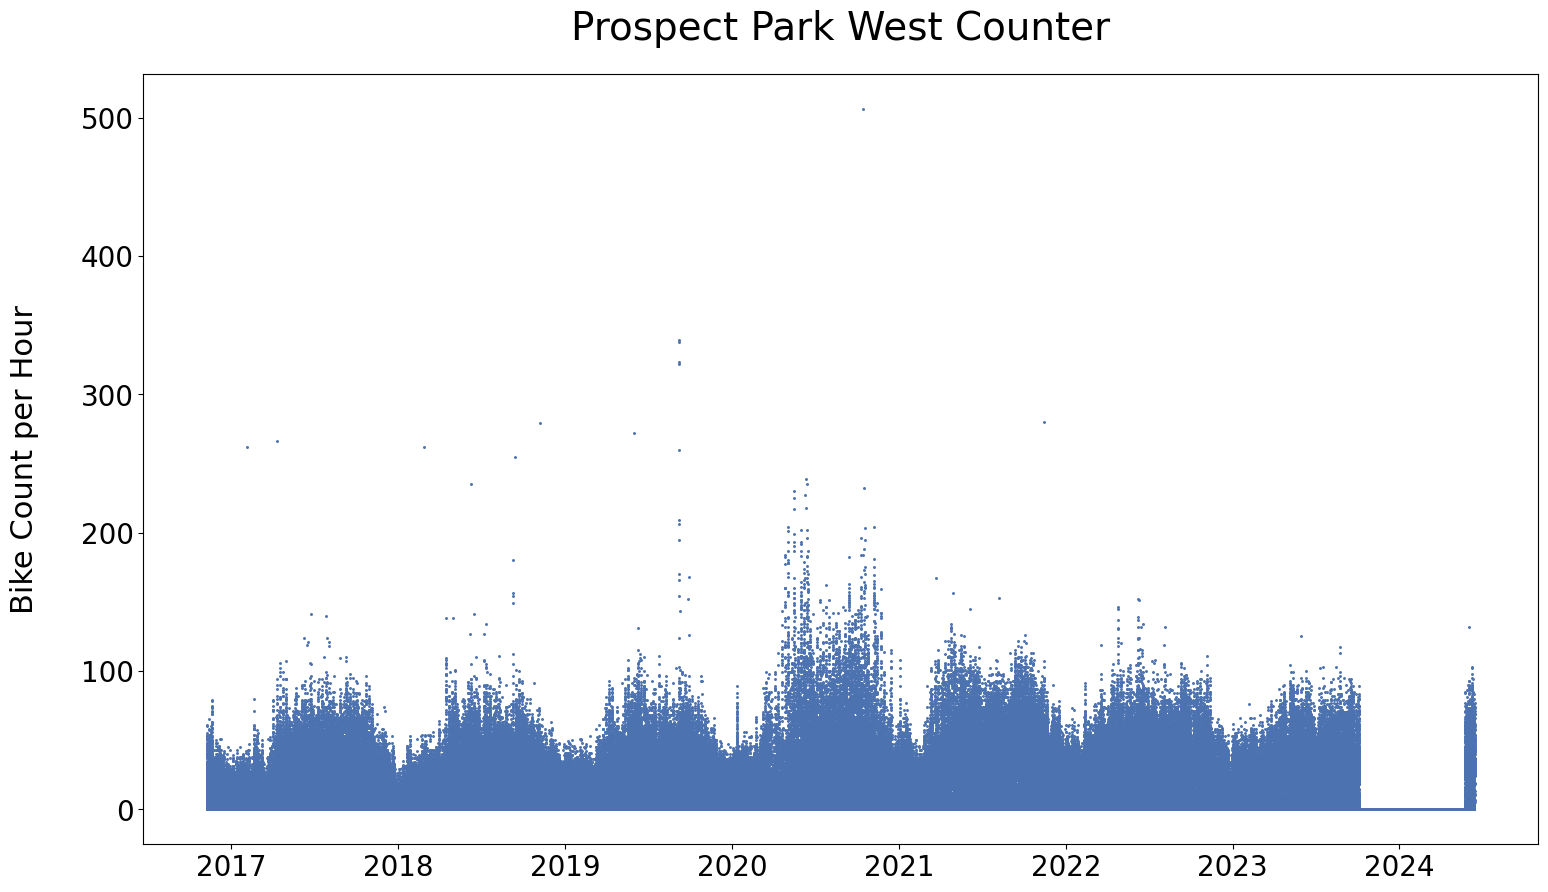

In [57]:
scatter_params = {
    "title": "Prospect Park West Counter",
    "ylabel": "Bike Count per Hour",
    "ylabel_rotation": "vertical",
}
with plt.style.context("default"):
    fig, ax = viz.setup_chart(**scatter_params)
    ax.scatter(ppw.index, ppw.values, s=5, marker=".")
    plt.show()

### Kent Ave Stations
While the older Kent Ave South station is approximately one kilometer from the Kent Ave North station (the station was relocated in November of 2016), they appear to have similar traffic patterns and can be jointly used in the measure of bike activity.

In [58]:
kan = counts[counts["name"] == "Kent Ave btw North 8th St and North 9th St"]["counts"]
kan.index.min(), kan.index.max()

(Timestamp('2016-11-22 17:00:00'), Timestamp('2024-06-13 23:45:00'))

In [59]:
kas = counts[counts["name"] == "Kent Ave btw South 6th St. and Broadway"]["counts"]
kas.index.min(), kas.index.max()

(Timestamp('2014-08-14 00:00:00'), Timestamp('2016-11-21 23:45:00'))

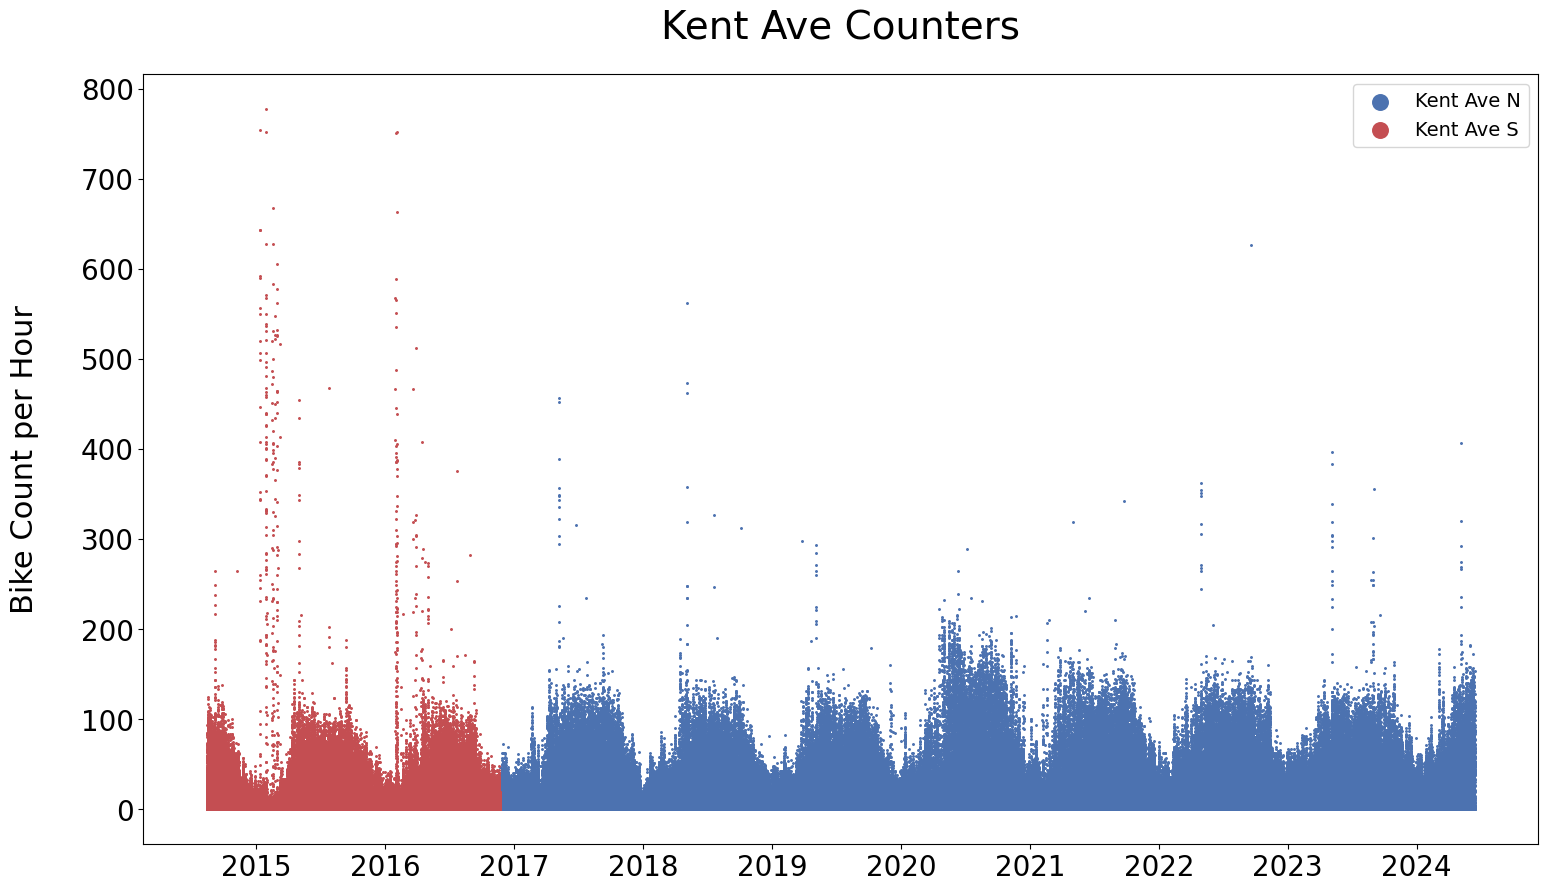

In [60]:
scatter_params = {
    "title": "Kent Ave Counters",
    "ylabel": "Bike Count per Hour",
    "ylabel_rotation": "vertical",
}
with plt.style.context("default"):
    fig, ax = viz.setup_chart(**scatter_params)
    ax.scatter(kan.index, kan.values, s=5, marker=".", label="Kent Ave N")
    ax.scatter(kas.index, kas.values, s=5, marker=".", label="Kent Ave S")
    ax.legend(fontsize=14, markerscale=10)
    plt.show()

In [61]:
kent_ave_combined = pd.concat([kas, kan])
kent_ave_combined.name = "Kent Ave"

In [62]:
ph.id_gaps_index(kent_ave_combined, pd.Timedelta(hours=1))

diffs
datetime                           
2015-12-02 04:00:00 6 days 00:15:00
2015-12-14 04:00:00 5 days 00:15:00
2023-07-01 02:45:00 2 days 03:00:00
2023-07-03 02:45:00 1 days 03:00:00
2015-11-05 04:00:00 1 days 00:15:00
2015-11-10 04:00:00 1 days 00:15:00
2016-11-22 17:00:00 0 days 17:15:00
2016-11-23 16:00:00 0 days 16:15:00
2016-12-14 15:00:00 0 days 15:15:00
2014-08-14 14:30:00 0 days 09:45:00
2014-11-02 05:00:00 0 days 01:15:00
2017-03-12 03:00:00 0 days 01:15:00
2018-03-11 03:00:00 0 days 01:15:00
2019-03-10 03:00:00 0 days 01:15:00
2020-03-08 03:00:00 0 days 01:15:00
2021-03-14 03:00:00 0 days 01:15:00
2022-03-13 03:00:00 0 days 01:15:00
2023-03-12 03:00:00 0 days 01:15:00
2016-03-13 03:00:00 0 days 01:15:00
2015-03-08 03:00:00 0 days 01:15:00
2024-03-10 03:00:00 0 days 01:15:00

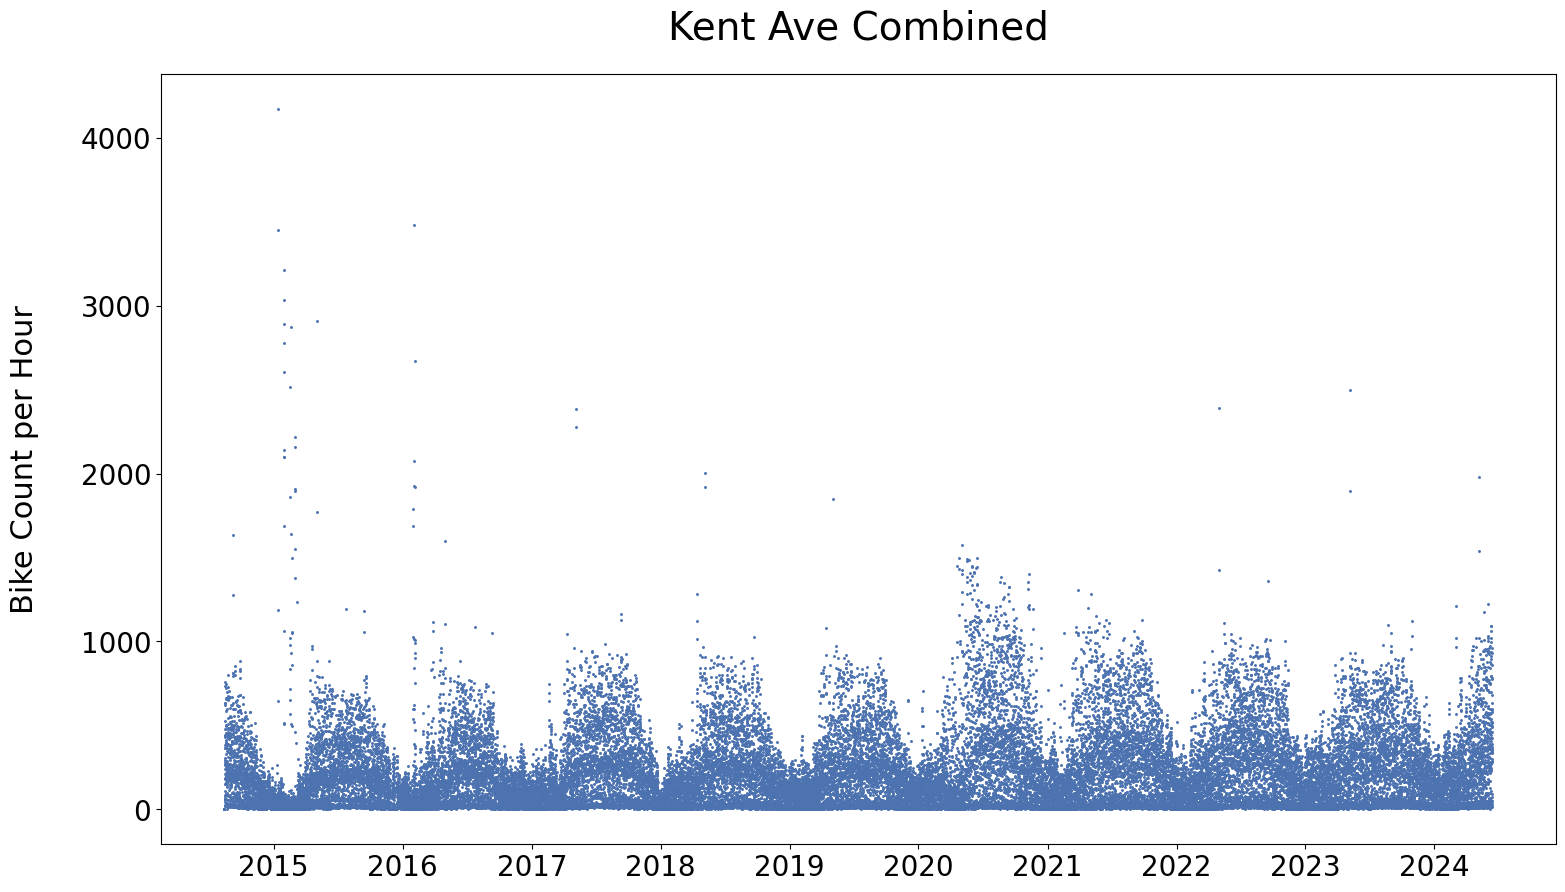

In [63]:
ka_resample = kent_ave_combined.resample("2h").sum()
scatter_params = {
    "title": "Kent Ave Combined",
    "ylabel": "Bike Count per Hour",
    "ylabel_rotation": "vertical",
}
with plt.style.context("default"):
    fig, ax = viz.setup_chart(**scatter_params)
    ax.scatter(ka_resample.index, ka_resample.values, s=5, marker=".")
    plt.show()

### Pulaski Bridge
Data does not appear to have started until mid-2017, therefore it would not be a good part of a bike activity measure that goes back to 2014 or 2015.

In [64]:
pul = counts[counts["name"] == "Pulaski Bridge"]["counts"]
pul.index.min(), pul.index.max()

(Timestamp('2017-06-24 00:00:00'), Timestamp('2024-06-13 23:45:00'))

### 26th Street
There 26th street data streams ended in 2019 and would not be a useful component of a bike activity measure

In [65]:
ave1 = counts[counts["name"] == "1st Avenue - 26th St N - Interference testing"][
    "counts"
]
ave1.index.min(), ave1.index.max()

(Timestamp('2013-09-11 22:00:00'), Timestamp('2019-12-05 16:45:00'))

In [66]:
ave2 = counts[counts["name"] == "2nd Avenue - 26th St S"]["counts"]
ave2.index.min(), ave2.index.max()

(Timestamp('2015-05-22 09:15:00'), Timestamp('2019-06-11 23:45:00'))

### 86th Street
There 86th street data streams started in 2019 and would not be a useful component of a bike activity measure

In [67]:
ams = counts[counts["name"] == "Amsterdam Ave at 86th St."]["counts"]
ams.index.min(), ams.index.max()

(Timestamp('2019-10-24 00:00:00'), Timestamp('2024-06-13 23:45:00'))

In [68]:
col = counts[counts["name"] == "Columbus Ave at 86th St."]["counts"]
col.index.min(), col.index.max()

(Timestamp('2019-10-24 00:00:00'), Timestamp('2024-06-12 23:45:00'))

## Creating and Reviewing Bicycle Activity Metric
There are 5 bike counters with complete data available from 2015 onwards. A 6th, the Staten Island ferry terminal, begins in early 2016. 
Given that the Staten Island ferry terminal numbers are small, we can add them without excessively distorting 2015 numbers. 

These 6 counters are located near or on the East River. Ideally we would have greater geographic diversity with bike meters, but these 6 counters do represent connections between four of the five boroughs (counties) in New York City. 

The counts per bike meter, while positively correlated, do show some variance in their patterns. The Williamsburg Bridge, Brooklyn Bridge, and Kent Ave meters show notable weekend activity.

We will use the following bike counts to create an overall metric for cycling activity: 
- Brooklyn Bridge
- Manhattan Bridge
- Williamsburg Bridge
- Queensboro Bridge
- Staten Island ferry terminal
- Combined Kent Ave. counters

In [69]:
components = pd.DataFrame(mb_count)
components["Queensboro Bridge"] = qbb["counts"]
components["Williamsburg Bridge"] = wb["counts"]
components["Brooklyn Bridge"] = bb[
    bb["name"] == "Comprehensive Brooklyn Bridge Counter"
]["counts"]
components["Staten Island Ferry"] = si["counts"]
components["Kent Ave - Williamsburg"] = kent_ave_combined

In [70]:
corr_matrix = components.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix[mask] = np.nan
corr_matrix.style.background_gradient(cmap="Blues", axis=None, low=0.6).highlight_null(
    color="#f1f1f1"
).format(precision=2)

In [71]:
components_post15 = components[
    (components.index.year >= 2015) & (components.index.year <= 2023)
]
time_range = components_post15.index.max() - components_post15.index.min()
total_days = time_range.round("1d").days
total_years = total_days / 365.25
total_weeks = total_days / 7

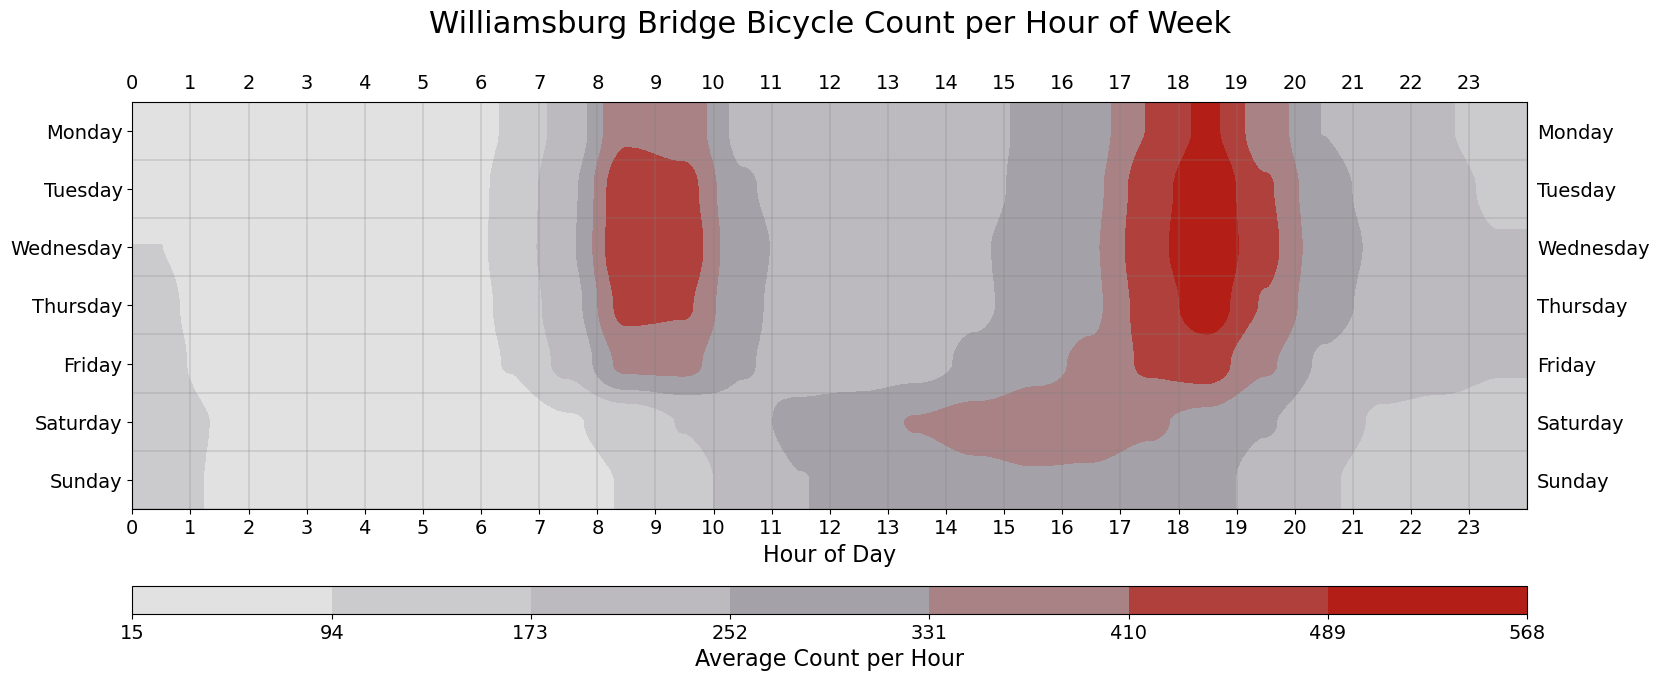

In [72]:
wb_ct = (
    pd.crosstab(
        index=components_post15.index.dayofweek,
        columns=components_post15.index.hour,
        values=components_post15["Williamsburg Bridge"].values,
        aggfunc="sum",
    )
    / total_weeks
)
wb_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
ct_labels = src.utils.make_heatmap_labels(
    "Williamsburg Bridge Bicycle Count per Hour of Week",
    cbar_label="Average Count per Hour",
)
viz.heat_map(
    wb_ct,
    ct_labels,
    interpolation="hanning",
    cbar_format=lambda x: f"{round(x, 0):,.0f}",
)

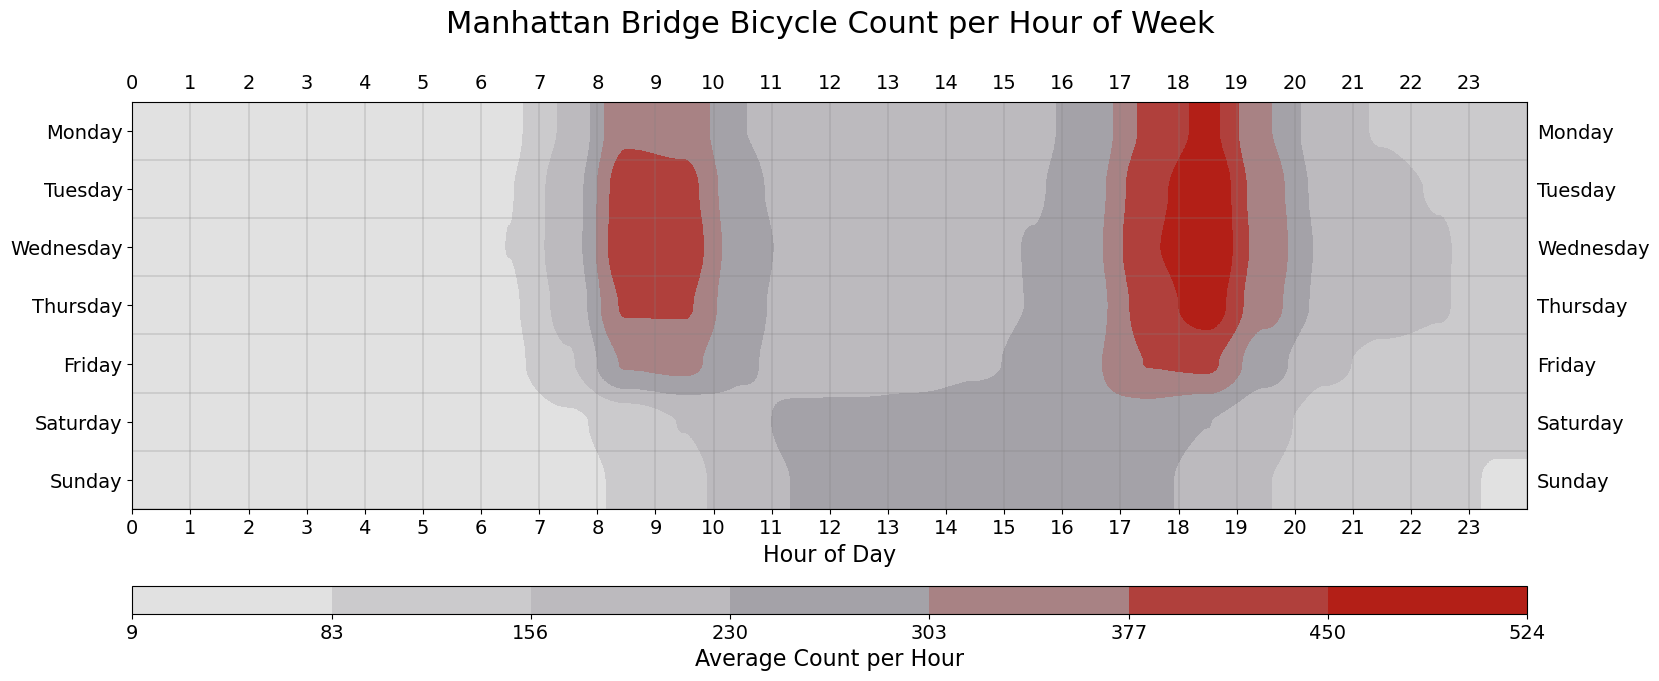

In [73]:
mb_ct = (
    pd.crosstab(
        index=components_post15.index.dayofweek,
        columns=components_post15.index.hour,
        values=components_post15["Manhattan Bridge Combined"].values,
        aggfunc="sum",
    )
    / total_weeks
)
mb_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
ct_labels = src.utils.make_heatmap_labels(
    "Manhattan Bridge Bicycle Count per Hour of Week",
    cbar_label="Average Count per Hour",
)
viz.heat_map(
    mb_ct,
    ct_labels,
    interpolation="hanning",
    cbar_format=lambda x: f"{round(x, 0):,.0f}",
)

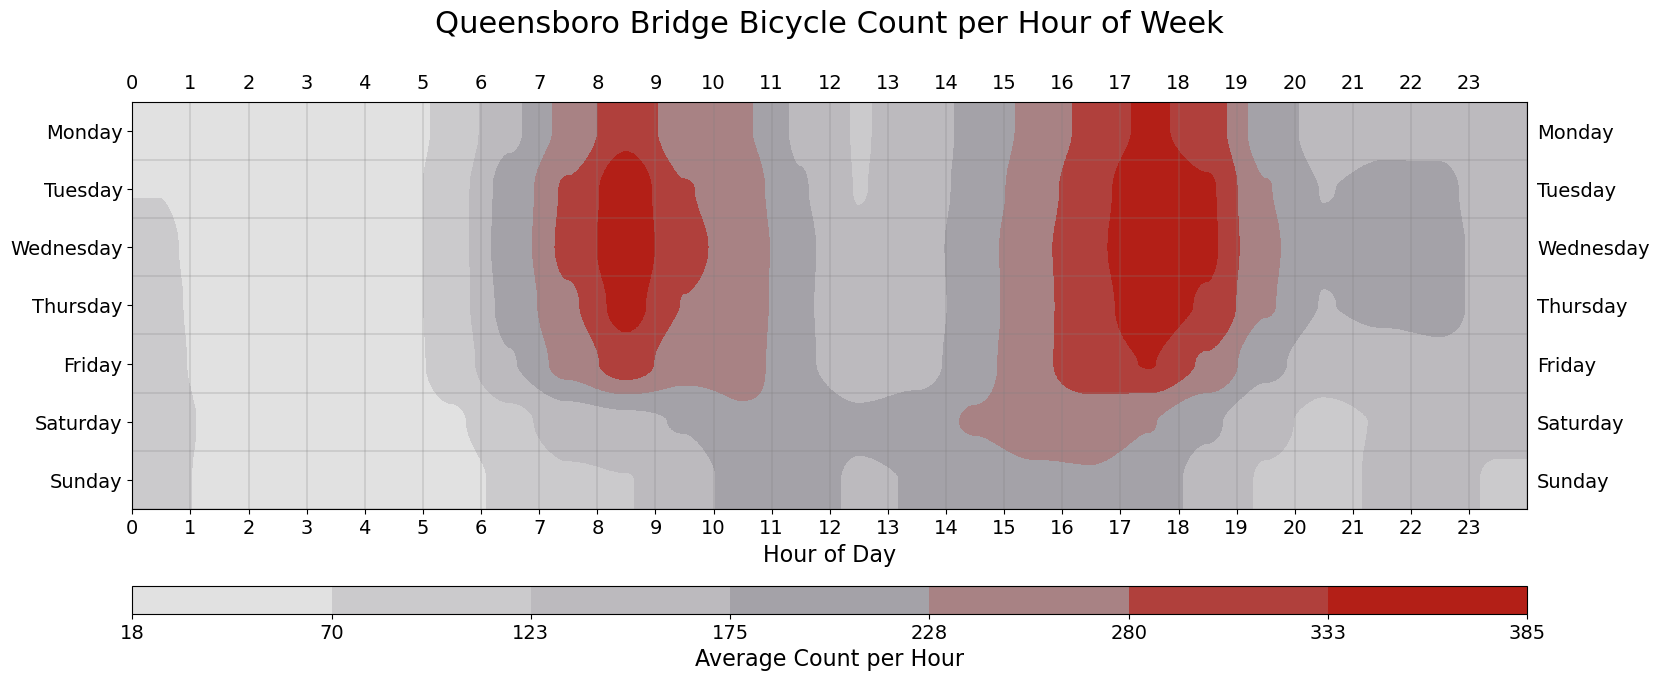

In [74]:
qb_ct = (
    pd.crosstab(
        index=components_post15.index.dayofweek,
        columns=components_post15.index.hour,
        values=components_post15["Queensboro Bridge"].values,
        aggfunc="sum",
    )
    / total_weeks
)
qb_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
ct_labels = src.utils.make_heatmap_labels(
    "Queensboro Bridge Bicycle Count per Hour of Week",
    cbar_label="Average Count per Hour",
)
viz.heat_map(
    qb_ct,
    ct_labels,
    interpolation="hanning",
    cbar_format=lambda x: f"{round(x, 0):,.0f}",
)

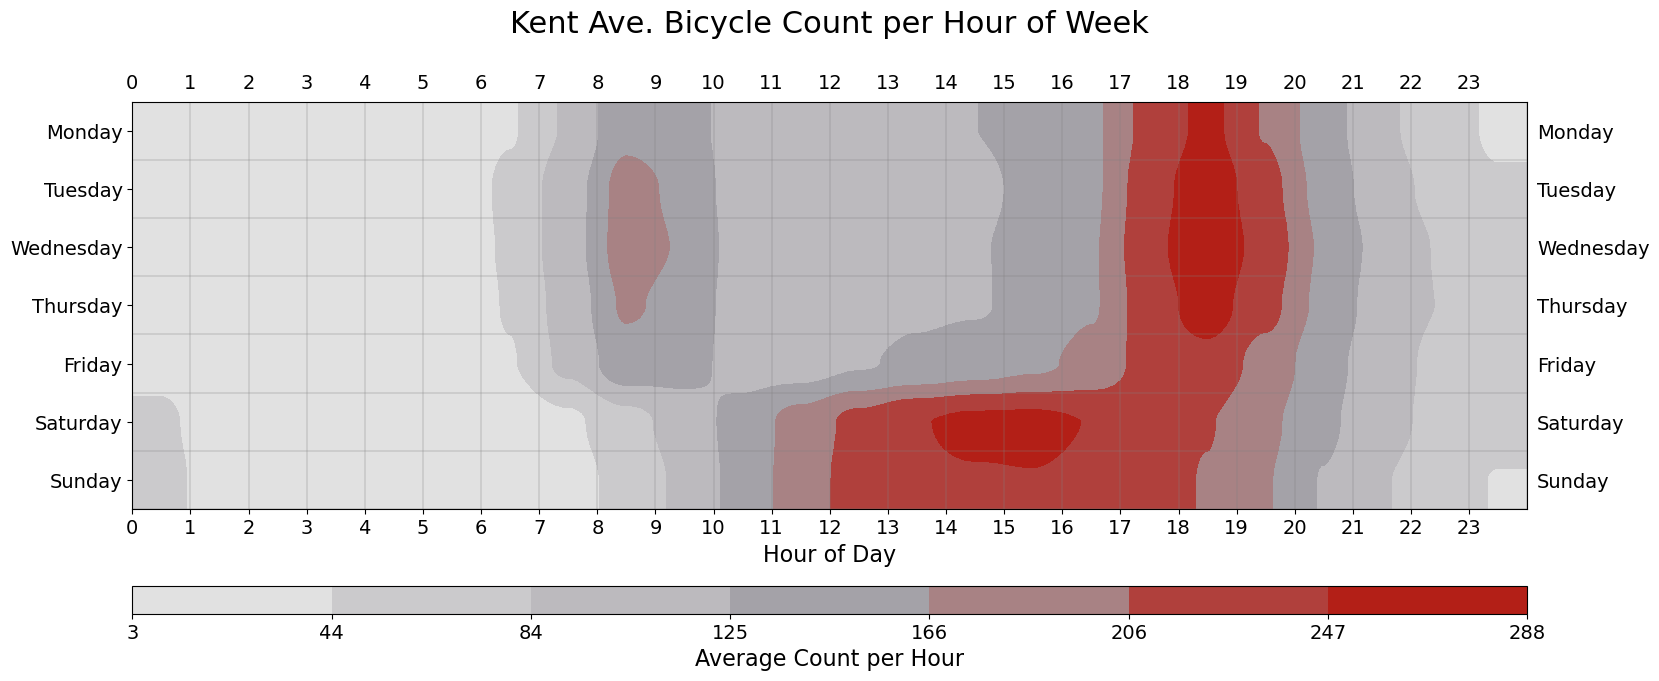

In [75]:
ka_ct = (
    pd.crosstab(
        index=components_post15.index.dayofweek,
        columns=components_post15.index.hour,
        values=components_post15["Kent Ave - Williamsburg"].values,
        aggfunc="sum",
    )
    / total_weeks
)
ka_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
ct_labels = src.utils.make_heatmap_labels(
    "Kent Ave. Bicycle Count per Hour of Week", cbar_label="Average Count per Hour"
)
viz.heat_map(
    ka_ct,
    ct_labels,
    interpolation="hanning",
    cbar_format=lambda x: f"{round(x, 0):,.0f}",
)

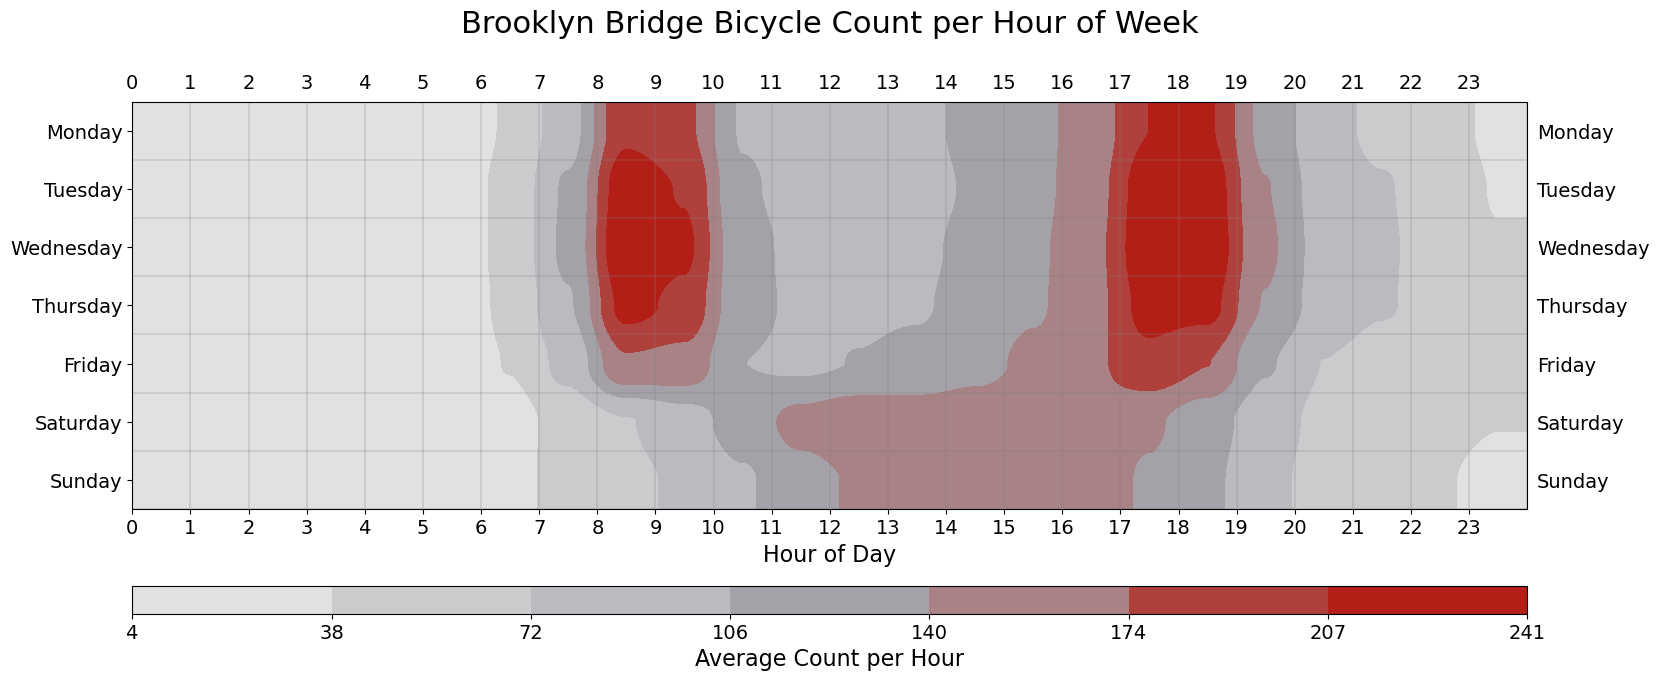

In [76]:
bb_ct = (
    pd.crosstab(
        index=components_post15.index.dayofweek,
        columns=components_post15.index.hour,
        values=components_post15["Brooklyn Bridge"].values,
        aggfunc="sum",
    )
    / total_weeks
)
bb_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
ct_labels = src.utils.make_heatmap_labels(
    "Brooklyn Bridge Bicycle Count per Hour of Week",
    cbar_label="Average Count per Hour",
)
viz.heat_map(
    bb_ct,
    ct_labels,
    interpolation="hanning",
    cbar_format=lambda x: f"{round(x, 0):,.0f}",
)

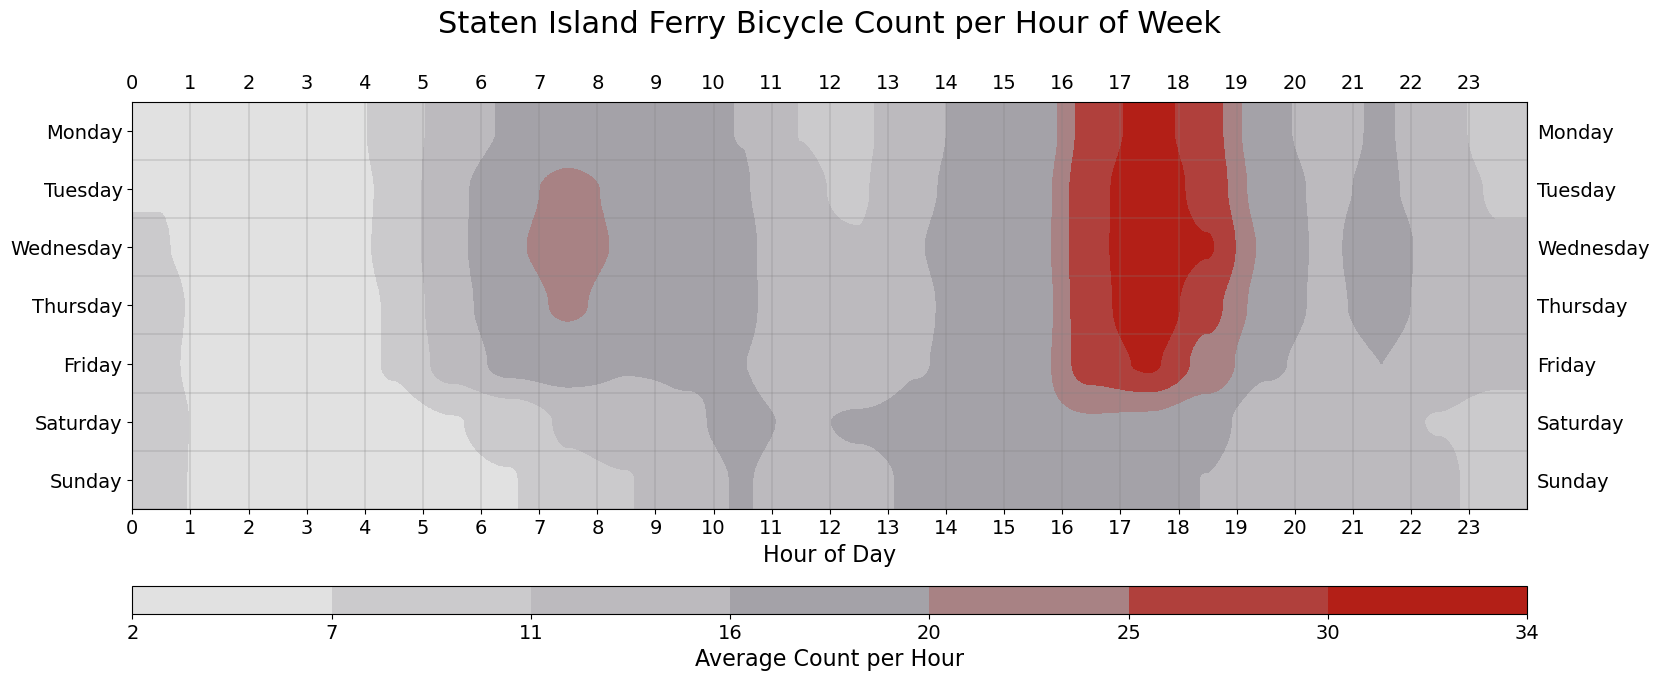

In [77]:
si_ct = (
    pd.crosstab(
        index=components_post15.index.dayofweek,
        columns=components_post15.index.hour,
        values=components_post15["Staten Island Ferry"].values,
        aggfunc="sum",
    )
    / total_weeks
)
si_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
ct_labels = src.utils.make_heatmap_labels(
    "Staten Island Ferry Bicycle Count per Hour of Week",
    cbar_label="Average Count per Hour",
)
viz.heat_map(
    si_ct,
    ct_labels,
    interpolation="hanning",
    cbar_format=lambda x: f"{round(x, 0):,.0f}",
)

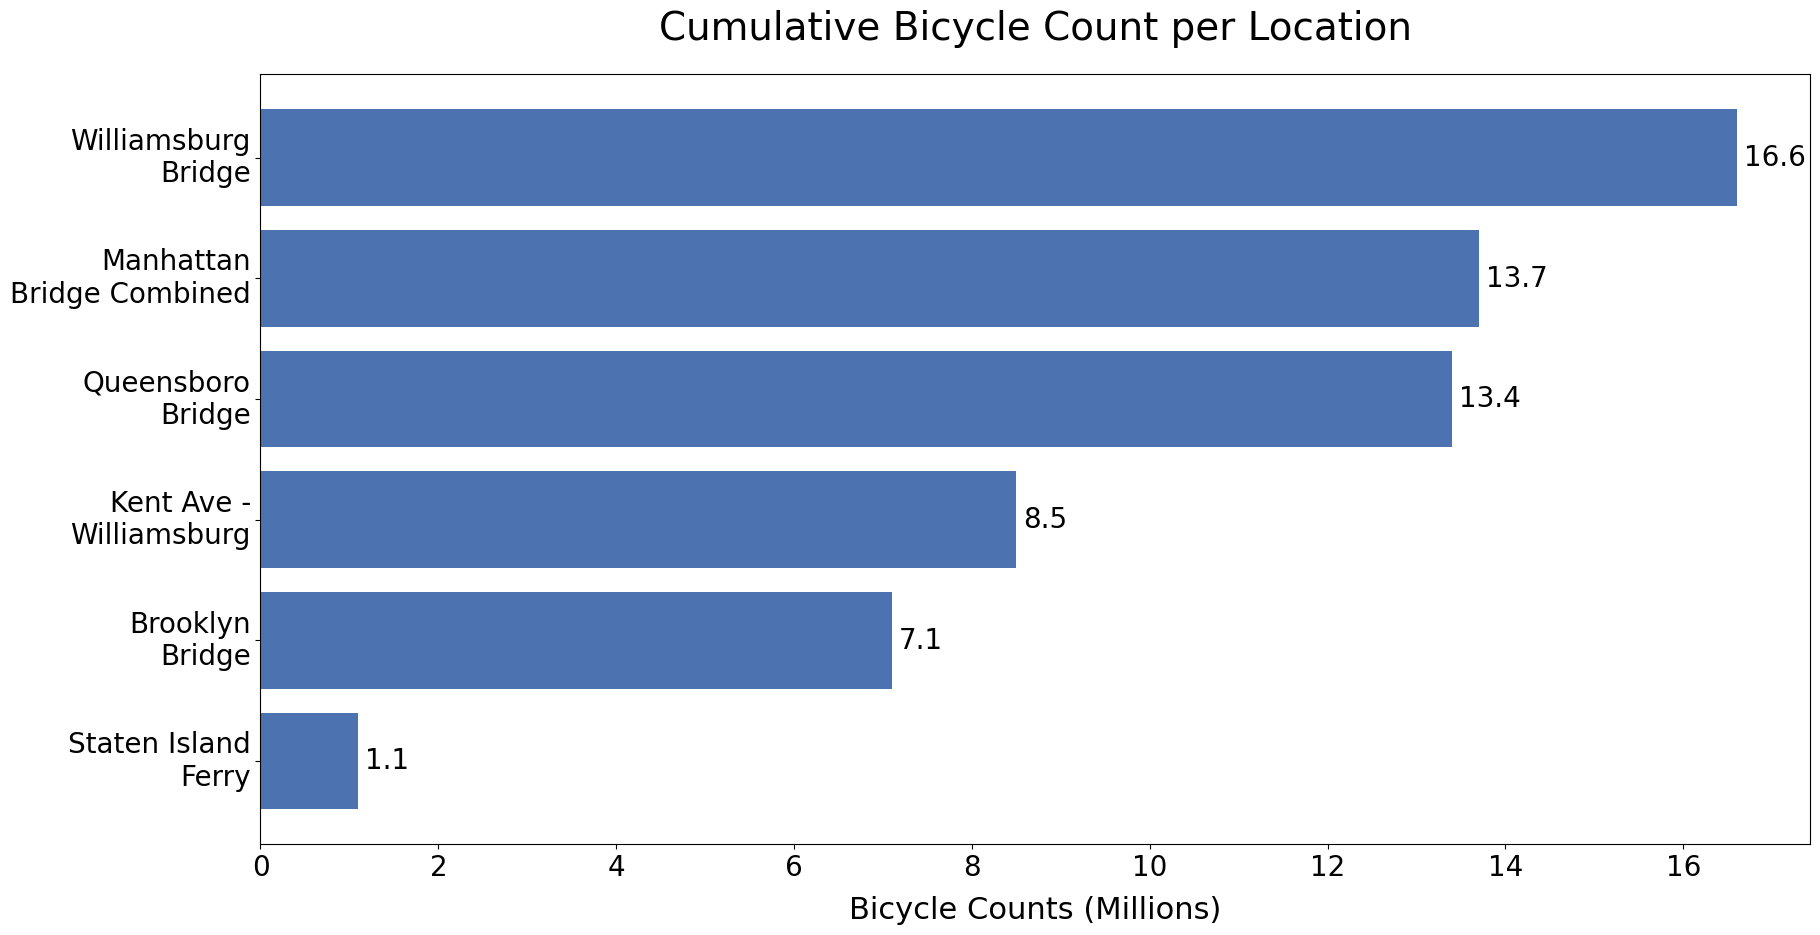

In [78]:
components_post15_sum = components_post15.sum().sort_values() / MILLION
bike_counts = [round(x, 1) for x in components_post15_sum.values]
title = "Cumulative Bicycle Count per Location"
x_label = "Bicycle Counts (Millions)"
bar_lables = add_line_breaks(components_post15_sum.index)
viz.horizontal_bar_chart(
    bar_lables,
    bike_counts,
    title=title,
    xlabel=x_label,
    figsize=(20, 10),
)

After 2013, the combined bike activity metric only has two gaps that do not correspond to daylight savings time. They are a ~24-gap and a ~90 minute gap in July 2023.

In [79]:
combined = components.sum(axis=1)[
    (components.index.year >= 2015) & (components.index.year <= 2023)
]
combined.index.min(), combined.index.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2023-12-31 23:45:00'))

In [80]:
ph.id_gaps_index(combined, pd.Timedelta(hours=1))

diffs
datetime                           
2023-07-03 00:45:00 1 days 01:00:00
2023-07-01 02:15:00 0 days 02:30:00
2015-03-08 03:00:00 0 days 01:15:00
2016-03-13 03:00:00 0 days 01:15:00
2017-03-12 03:00:00 0 days 01:15:00
2018-03-11 03:00:00 0 days 01:15:00
2019-03-10 03:00:00 0 days 01:15:00
2020-03-08 03:00:00 0 days 01:15:00
2021-03-14 03:00:00 0 days 01:15:00
2022-03-13 03:00:00 0 days 01:15:00
2023-03-12 03:00:00 0 days 01:15:00

In [81]:
combined_hourly = combined.resample("1h").sum()
combined_hourly.name = "NYC Bicycle Counts"

In [82]:
ph.SeriesProfile(combined_hourly, time_index=True)

NYC Bicycle Counts Info
-------------------------  -------
Data Type                  float64
Count                      78888
Unique Values              3248
Null Values                0

  Value    Count  % of total
-------  -------  ------------
     86      150  0.19%
     52      150  0.19%
     72      148  0.19%
     73      147  0.19%
     71      144  0.18%
     51      144  0.18%
     58      143  0.18%
     68      142  0.18%
     61      141  0.18%
     70      140  0.18%
   3187        1  0.00%
   3442        1  0.00%
   2660        1  0.00%
   2239        1  0.00%
   3428        1  0.00%

Statistic                        Value
-------------------------  -----------
count                      78888
min                            0
1%                            24
5%                            52
25%                          215
50%                          591
75%                         1144
95%                         2125.65
99%                         2821.13
max                         3739
mean                         766.579
standard deviation           668.934
median                       591
median absolute deviation    429
skew                           1.13347

Time Diffs         Count  % of total
---------------  -------  ------------
0 days 01:00:00    78887  100.00%

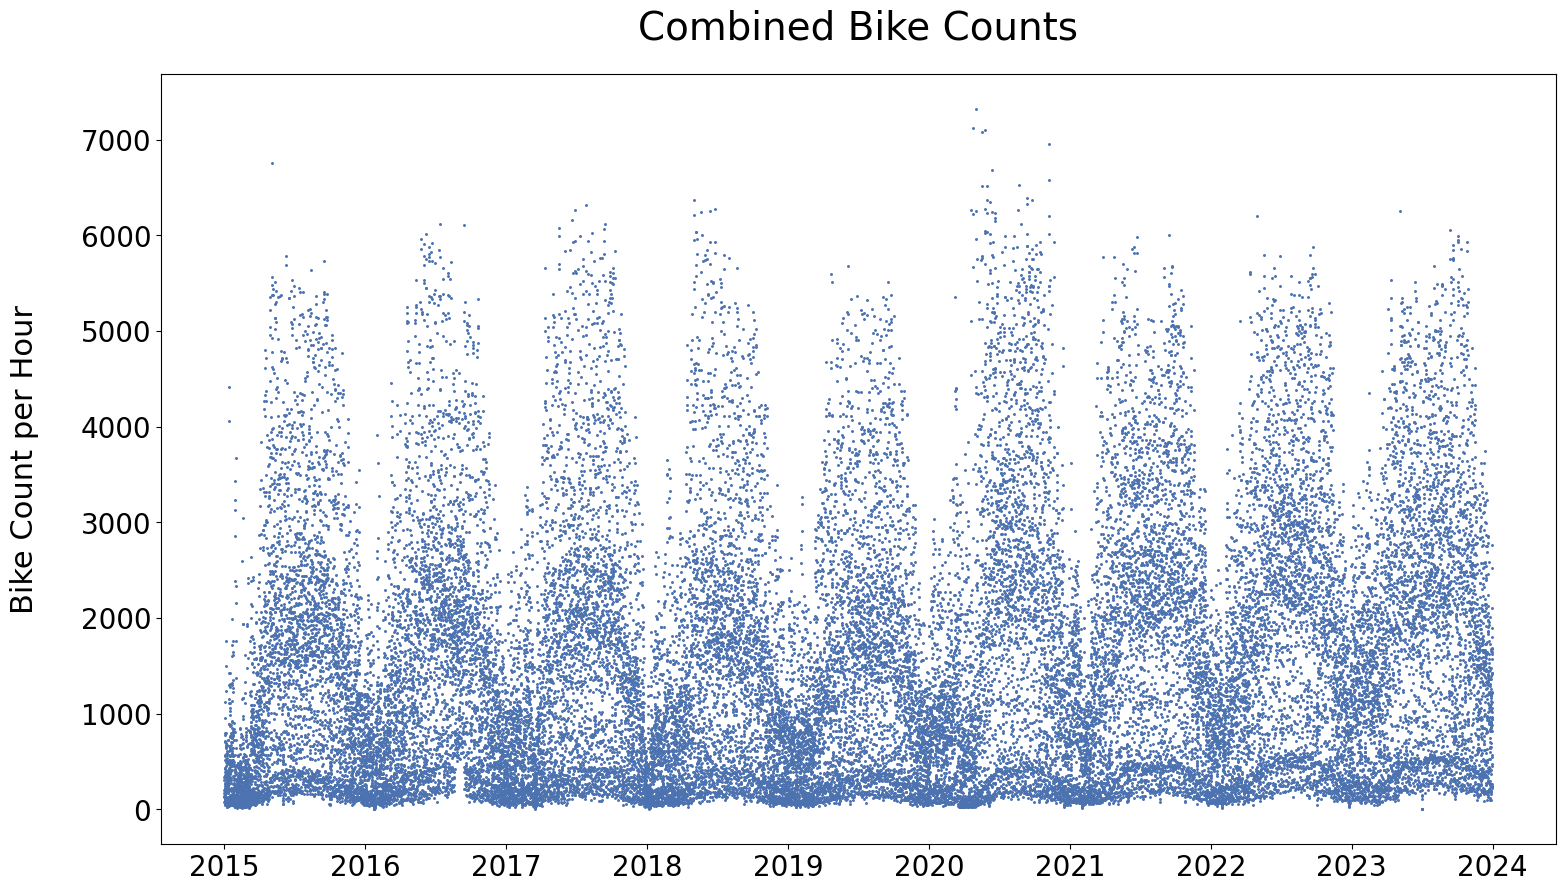

In [83]:
combined_2hr = combined_hourly.resample("2h").sum()
scatter_params = {
    "title": "Combined Bike Counts",
    "ylabel": "Bike Count per Hour",
    "ylabel_rotation": "vertical",
}
with plt.style.context("default"):
    fig, ax = viz.setup_chart(**scatter_params)
    ax.scatter(combined_2hr.index, combined_2hr.values, s=5, marker=".")
    ax.xaxis.set_major_locator(mpl.dates.YearLocator(1))
    plt.show()

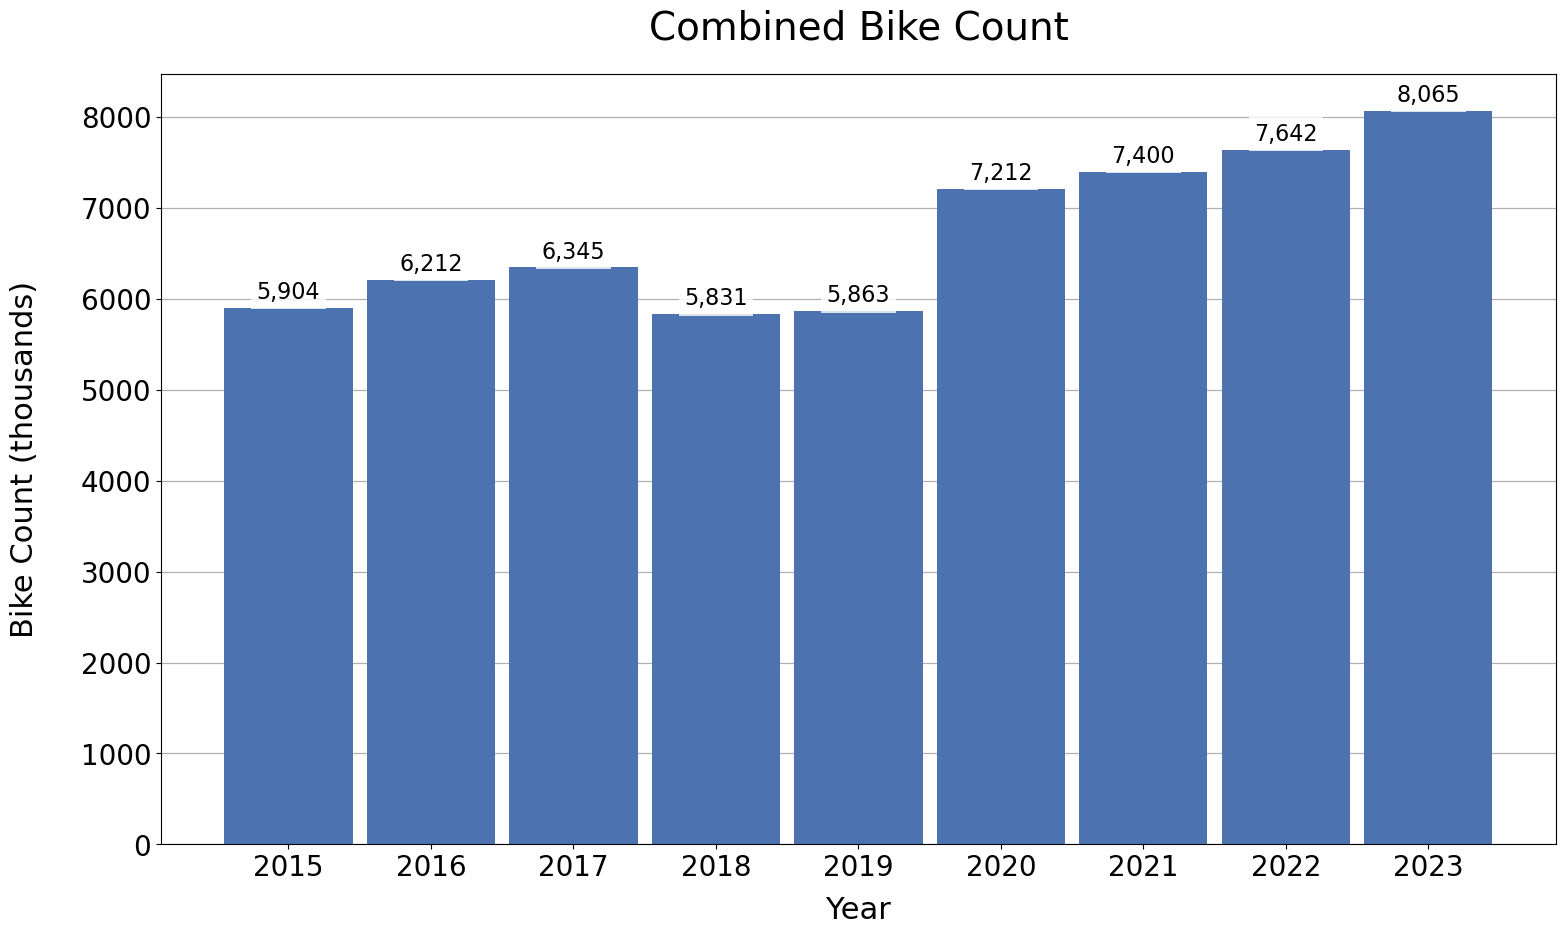

In [84]:
yearly_groupby = pd.DataFrame(
    combined_hourly.groupby(by=combined_hourly.index.year).sum()
)
viz.grouped_bar_chart(
    yearly_groupby / THOUSAND,
    title="Combined Bike Count",
    xlabel="Year",
    ylabel="Bike Count (thousands)",
    ylabel_rotation="vertical",
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
)

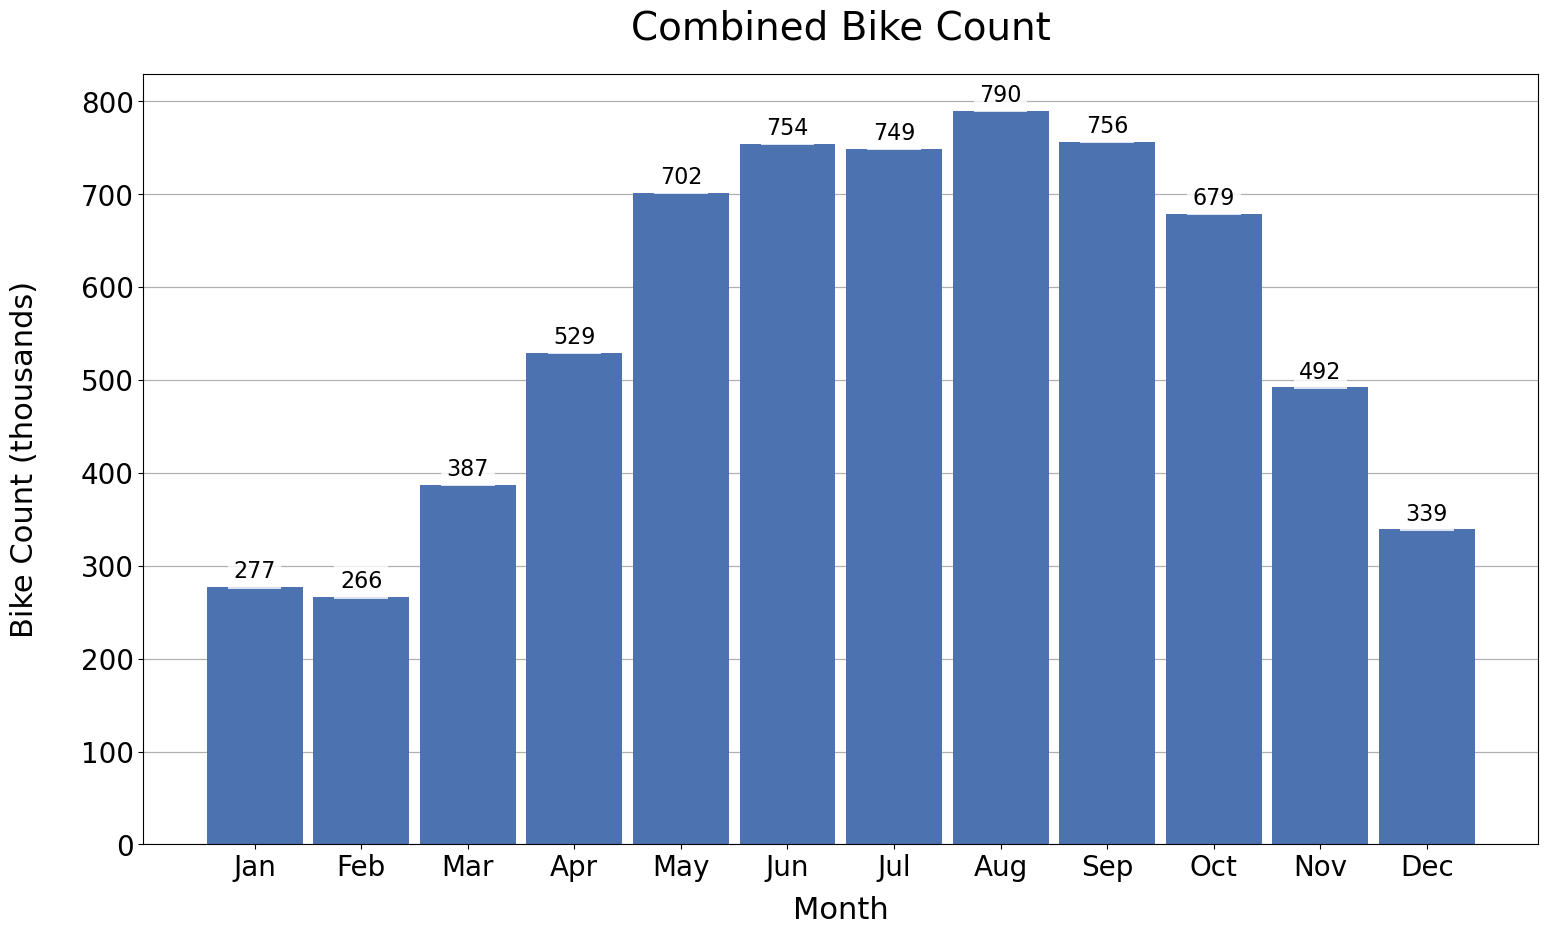

In [85]:
monthly_groupby = (
    pd.DataFrame(combined_hourly.groupby(by=combined_hourly.index.month).sum())
    / total_years
)
monthly_groupby.index = monthly_groupby.index.map(MONTHS_MAP)
viz.grouped_bar_chart(
    monthly_groupby / THOUSAND,
    title="Combined Bike Count",
    xlabel="Month",
    ylabel="Bike Count (thousands)",
    ylabel_rotation="vertical",
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
)

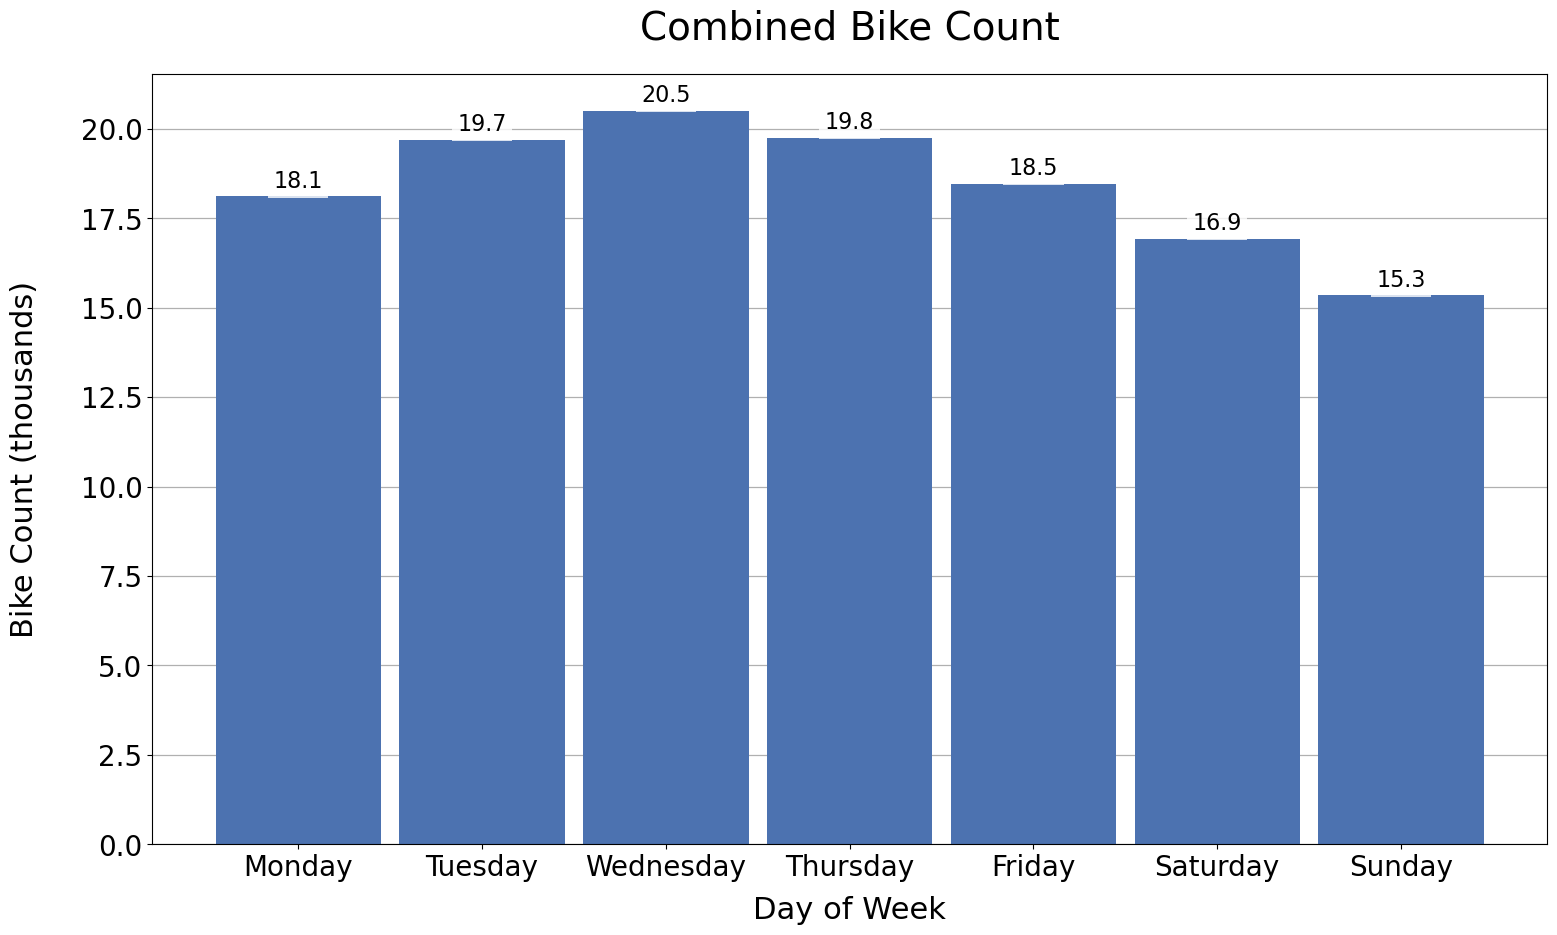

In [86]:
daily_groupby = (
    pd.DataFrame(combined_hourly.groupby(by=combined_hourly.index.dayofweek).sum())
    / total_weeks
)
daily_groupby.index = daily_groupby.index.map(DAY_OF_WEEK_MAP)
viz.grouped_bar_chart(
    daily_groupby / THOUSAND,
    title="Combined Bike Count",
    titlesize=28,
    xlabel="Day of Week",
    ylabel="Bike Count (thousands)",
    ylabel_rotation="vertical",
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    bar_digits=1,
)

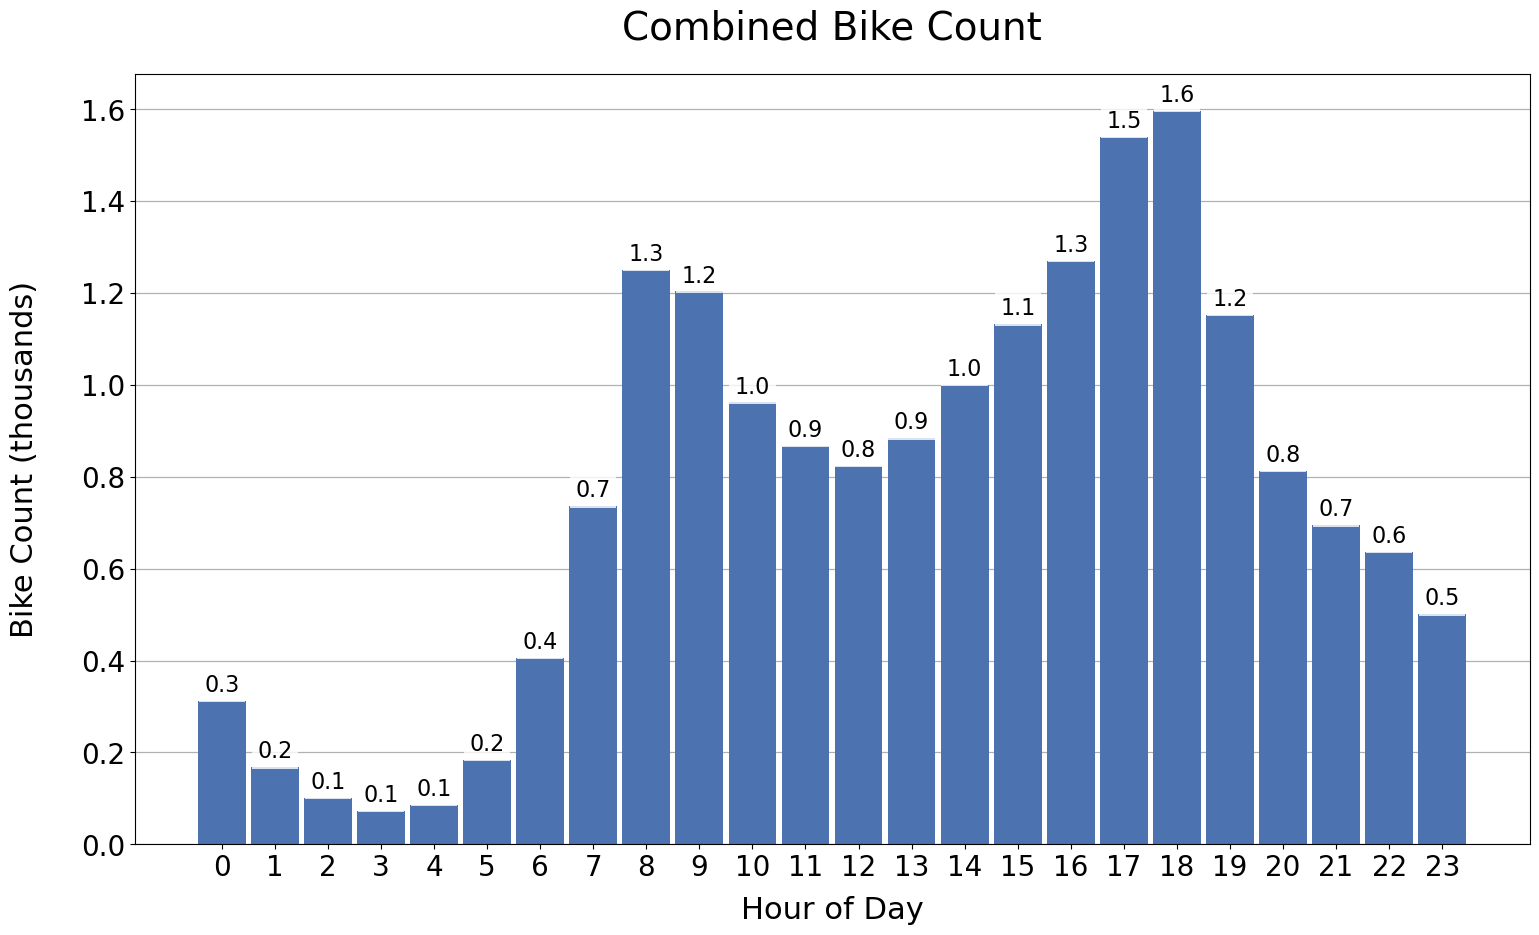

In [87]:
hourly_groupby = (
    pd.DataFrame(combined_hourly.groupby(by=combined_hourly.index.hour).sum())
    / total_days
)
viz.grouped_bar_chart(
    hourly_groupby / THOUSAND,
    title="Combined Bike Count",
    xlabel="Hour of Day",
    ylabel="Bike Count (thousands)",
    ylabel_rotation="vertical",
    yaxis_format="{x:,.1f}",
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    bar_digits=1,
)

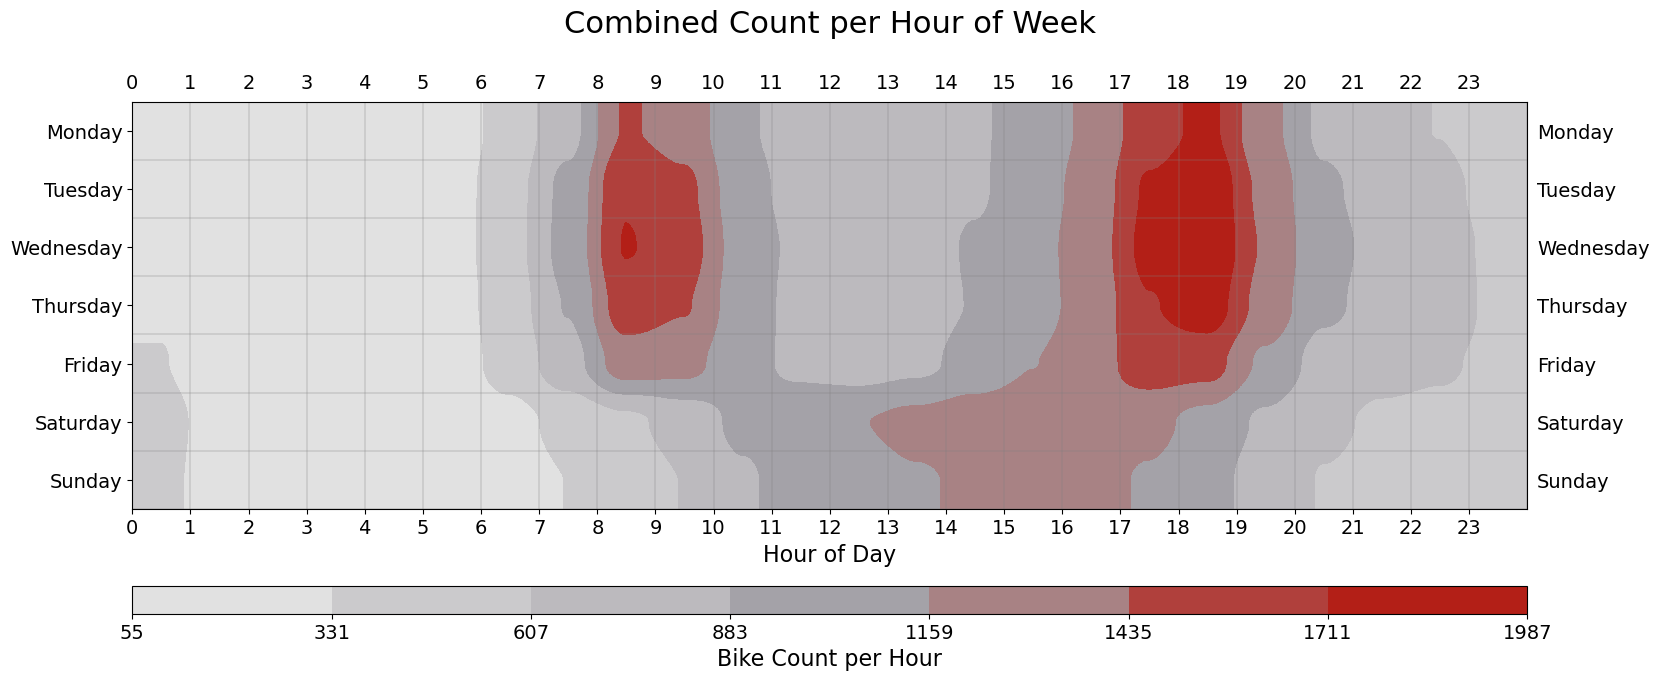

In [88]:
combined_ct = (
    pd.crosstab(
        index=combined_hourly.index.dayofweek,
        columns=combined_hourly.index.hour,
        values=combined_hourly.values,
        aggfunc="sum",
    )
    / total_weeks
)
combined_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
ct_labels = src.utils.make_heatmap_labels(
    "Combined Count per Hour of Week", cbar_label="Bike Count per Hour"
)
viz.heat_map(
    combined_ct,
    ct_labels,
    interpolation="hanning",
    cbar_format=lambda x: f"{round(x, 0):.0f}",
)

In [89]:
int(combined_hourly.quantile(0.001))

7

Setting any value below the 0.1 percentile to the same value as the 0.1 percentile to prevent any divide by zero errors when using the bike activity index.

In [90]:
combined_hourly[combined_hourly < int(combined_hourly.quantile(0.001))] = int(
    combined_hourly.quantile(0.001)
)

In [91]:
combined_hourly.min()

7.0

In [92]:
combined_hourly = pd.DataFrame(combined_hourly)

In [93]:
combined_hourly.to_pickle(PROCESSED_DATA_LOC)

# Conclusion

**A useful proxy for overall NYC bike activity levels can be constructed using the NYC Bike Counts dataset.**
- It is a large hourly sample that links four of the five boroughs in NYC.
- The bike counters, while postively correlated, show variation in the their patterns. The bike traffic does not just follow a Monday-Friday commutting pattern.
- The weekly and daily periodicity is inline with typical traffic patterns, suggesting that the data is a useful proxy for citywide bike activity levels.